In [1]:
import pandas as pd
import numpy as np
import requests
import random
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection

In [712]:
NHL_BASE_URL = "http://statsapi.web.nhl.com"


"""
PLAY-OFF GAMES CODES
==============================================================================
2015 | 03 | 04 | 12 

2015 = season code, first year of the season (e.g., 2015 is for the 2015-16 seasons)
03   = game type code; 1 = preseason, 2 = regular season; 3 = playoffs
04   = playoff only: round number (1st round = 1, 2nd round = 2, ECF/WCF = 3, SCF = 4)
1    = series number: 1-8 in round 1, 1-4 in round 2, 1-2 in round 3, 1 in round 4
2    = game number: 1-7 for any given series
==============================================================================

REGULAR SEASON / PRE SEASON GAMES CODES
==============================================================================
2015 | 02 | 0807
2015 = season code, first year of the season (e.g., 2015 is for the 2015-16 seasons)
02   = game type code; 1 = preseason, 2 = regular season; 3 = playoffs
0807 = game ID; generally 1-1230 in a normal regular season, but sometimes games will be missing 
       (e.g., games cancelled due to weather) and sometimes games will be added on the end, starting
        with 1231 (e.g., make-up games for weather-cancelled games). Numbers are usually approx. 
        1-130ish in the pre-season, but it can be arbitrary.
==============================================================================
"""
years = range(2005, 2006)
game_types = [3]
game_id_preseason = range(1, 140)
game_id_season = range(0, 1300)
cap_break = 1500*18

games_code_list = []
for year in years:
    for game_type in game_types:
        if game_type == 1:
            for game_id in game_id_preseason:
                games_code_list.append("{0}{1:02d}{2:04d}".format(year, game_type, game_id))
        elif game_type == 2:
            for game_id in game_id_season:
                games_code_list.append("{0}{1:02d}{2:04d}".format(year, game_type, game_id))
        elif game_type == 3:
            # 2015 | 03 | 04 | 12
            for playoff in range(1, 5):
                for series in range(1, 9):
                    for game in range(1, 8):
                        games_code_list.append("{0}{1:02d}{2:02d}{3}{4}".format(year, game_type, playoff, series, game))
#print(games_code_list)

game_list = []
error_count = 0

for idx, game_code in enumerate(games_code_list):
    nhl_game_url = "{0}/api/v1/game/{1}/feed/live".format(NHL_BASE_URL, game_code)
    r = requests.get(nhl_game_url)

    print("{0}/{1} - {2}".format(idx, len(games_code_list),game_code))

    if idx > cap_break:
        break

    if r.status_code == 200:    # valid request
        print("Request {0} Successful".format(nhl_game_url))
        r_json = r.json()
        try:
            game = r_json['gameData']
            #start_time = game['datetime']['dateTime']
            #end_time = game['datetime']['endDateTime']

            away_team = game['teams']['away']
            home_team = game['teams']['home']
            away_team_name = away_team['name']
            home_team_name = home_team['name']

            boxscore = r_json['liveData']['boxscore']
            #offical_id = boxscore['officials'][0]['official']['id']
            official_name1 = boxscore['officials'][0]['official']['fullName']
            official_name2 = boxscore['officials'][1]['official']['fullName']

            away_score = boxscore["teams"]["away"]["teamStats"]["teamSkaterStats"]["goals"]
            home_score = boxscore["teams"]["home"]["teamStats"]["teamSkaterStats"]["goals"]
            if away_score > home_score:
                win = away_team_name
            else:
                win = home_team_name

            row_dict = {"code": game_code,
                        'away_team': away_team_name,
                        'away_score' : away_score,
                        'home_team': home_team_name,
                        "home_score" : home_score,
                        "winner" : win,
                        'official_1': official_name1,
                        "official_2" : official_name2}
            game_list.append(row_dict)
            #print('something')
        except (KeyError, IndexError):
            print("ERROR {0}".format(nhl_game_url))
            error_count += 1
    else:
        print("No Response")

#print(game_df)

game_df = pd.DataFrame(game_list)
game_df = game_df.set_index("code")
game_df1 = game_df[["home_team","home_score","away_team","away_score","official_1","official_2","winner"]]

def loser(row):
    if row["winner"] == row["away_team"]:
        return row["home_team"]
    return row["away_team"]
    

game_df1["loser"] = game_df1.apply(loser, axis=1)

game_df1.to_csv("2005_playoff_data.csv")

0/224 - 2005030111
Request http://statsapi.web.nhl.com/api/v1/game/2005030111/feed/live Successful
1/224 - 2005030112
Request http://statsapi.web.nhl.com/api/v1/game/2005030112/feed/live Successful
2/224 - 2005030113
Request http://statsapi.web.nhl.com/api/v1/game/2005030113/feed/live Successful
3/224 - 2005030114
Request http://statsapi.web.nhl.com/api/v1/game/2005030114/feed/live Successful
4/224 - 2005030115
Request http://statsapi.web.nhl.com/api/v1/game/2005030115/feed/live Successful
5/224 - 2005030116
No Response
6/224 - 2005030117
No Response
7/224 - 2005030121
Request http://statsapi.web.nhl.com/api/v1/game/2005030121/feed/live Successful
8/224 - 2005030122
Request http://statsapi.web.nhl.com/api/v1/game/2005030122/feed/live Successful
9/224 - 2005030123
Request http://statsapi.web.nhl.com/api/v1/game/2005030123/feed/live Successful
10/224 - 2005030124
Request http://statsapi.web.nhl.com/api/v1/game/2005030124/feed/live Successful
11/224 - 2005030125
Request http://statsapi.we

116/224 - 2005030315
Request http://statsapi.web.nhl.com/api/v1/game/2005030315/feed/live Successful
117/224 - 2005030316
Request http://statsapi.web.nhl.com/api/v1/game/2005030316/feed/live Successful
118/224 - 2005030317
Request http://statsapi.web.nhl.com/api/v1/game/2005030317/feed/live Successful
119/224 - 2005030321
Request http://statsapi.web.nhl.com/api/v1/game/2005030321/feed/live Successful
120/224 - 2005030322
Request http://statsapi.web.nhl.com/api/v1/game/2005030322/feed/live Successful
121/224 - 2005030323
Request http://statsapi.web.nhl.com/api/v1/game/2005030323/feed/live Successful
122/224 - 2005030324
Request http://statsapi.web.nhl.com/api/v1/game/2005030324/feed/live Successful
123/224 - 2005030325
Request http://statsapi.web.nhl.com/api/v1/game/2005030325/feed/live Successful
124/224 - 2005030326
No Response
125/224 - 2005030327
No Response
126/224 - 2005030331
No Response
127/224 - 2005030332
No Response
128/224 - 2005030333
No Response
129/224 - 2005030334
No Res

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [713]:
game_df1.head()

home_team  home_score            away_team  away_score  \
code                                                                           
2005030111      Ottawa Senators           4  Tampa Bay Lightning           1   
2005030112      Ottawa Senators           3  Tampa Bay Lightning           4   
2005030113  Tampa Bay Lightning           4      Ottawa Senators           8   
2005030114  Tampa Bay Lightning           2      Ottawa Senators           5   
2005030115      Ottawa Senators           3  Tampa Bay Lightning           2   

               official_1          official_2               winner  \
code                                                                 
2005030111   Dave Jackson         Brad Watson      Ottawa Senators   
2005030112       Tim Peel  Don VanMassenhoven  Tampa Bay Lightning   
2005030113   Kerry Fraser        Eric Furlatt      Ottawa Senators   
2005030114  Bill McCreary    Kelly Sutherland      Ottawa Senators   
2005030115  Dan Marouelli        Dennis LaRue      Ottawa Senators   

                          loser  
code                             
2005030111  Tampa Bay Lightning  
2005030112      Ottawa Senators  
2005030113  Tampa Bay Lightning  
2005030114  Tampa Bay Lightning  
2005030115  Tampa Bay Lightning

In [738]:
for i in range(1994, 2017):
    if i == 2004:
        continue
    file_name = "{0}_playoff_data.csv".format(i)
    df = pd.read_csv(file_name)
    team = df.home_team.unique()
    team1 = df.away_team.unique()
    official1 = df.official_1.unique()
    official2 = df.official_2.unique()
    df1 = pd.DataFrame(team)
    df2 = pd.DataFrame(team1)
    df3 = pd.DataFrame(official1)
    df4 = pd.DataFrame(official2)
    teams = df1
    refs = df3.append(df4)
    refs1 = refs[0].unique()
    officials = pd.DataFrame(refs1)
    team = pd.DataFrame(sorted(teams[0]))
    official = pd.DataFrame(sorted(officials[0]))

    e = []

    for a in df.index:
        for b in sorted(officials[0]):
            for c in sorted(teams[0]):
                if df.loc[a]["away_team"] == c:
                    if df.loc[a]["official_1"] == b:
                        d = df.loc[a]["away_score"]
                        e.append({"Ref": b, "Team": c, "Score": d})
                    if df.loc[a]["official_2"] == b:
                        d = df.loc[a]["away_score"]
                        e.append({"Ref": b, "Team": c, "Score": d})
                if df.loc[a]["home_team"] == c:
                    if df.loc[a]["official_1"] == b:
                        d = df.loc[a]["home_score"]
                        e.append({"Ref": b, "Team": c, "Score": d})
                    if df.loc[a]["official_2"] == b:
                        d = df.loc[a]["home_score"]
                        e.append({"Ref": b, "Team": c, "Score": d})
    cleaned = pd.DataFrame(e)
    save_file_name = "{0}_playoff_data_cleaned.csv".format(i)
    cleaned.to_csv(save_file_name)

In [739]:
df_all = pd.DataFrame()

for i in range(1994, 2017):
    if i == 2004:
        continue
    file_name = "{0}_playoff_data_cleaned.csv".format(i)

    df = pd.read_csv(file_name, index_col="Unnamed: 0")
    df['Year'] = i
    df.set_index('Year', inplace=True)
    df_all = df_all.append(df)
    
df_all.to_csv("all_playoff_data_cleaned.csv")

In [49]:
df = pd.read_csv("all_data_cleaned.csv", index_col="Year")

e = []

for i in df.Ref.unique():
    for j in df.Team.unique():
        a = df.loc[((df["Ref"] == i) & (df["Team"] == j)), "Score"].sum() / df.loc[((df["Ref"] == i) & (df["Team"] == j)), "Score"].count()
        e.append({"Ref": i, "Team": j, "Goals per Game": a})

goals_per_game = pd.DataFrame(e)       
goals_per_game.head()

Ref  Score                 Team
Year                                           
1994  Bill McCreary      2       Buffalo Sabres
1994  Bill McCreary      1     New York Rangers
1994  Kevin Collins      2       Buffalo Sabres
1994  Kevin Collins      1     New York Rangers
1994   Dave Jackson      5  Pittsburgh Penguins

In [69]:
e = []

for i in df.Ref.unique():
    for j in df.Team.unique():
        a = df.loc[((df["Ref"] == i) & (df["Team"] == j)), "Score"].sum() / df.loc[((df["Ref"] == i) & (df["Team"] == j)), "Score"].count()
        e.append({"Ref": i, "Team": j, "Goals per Game": a})

goals_per_game = pd.DataFrame(e)       

goals_per_game = goals_per_game[['Ref', 'Team', 'Goals per Game']]

goals_per_game.to_csv("goals_per_game.csv")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


Goals per Game            Ref                 Team
0        2.990000  Bill McCreary       Buffalo Sabres
1        2.447619  Bill McCreary     New York Rangers
2        2.720000  Bill McCreary  Pittsburgh Penguins
3        2.571429  Bill McCreary  Tampa Bay Lightning
4        2.500000  Bill McCreary   Chicago Blackhawks

In [3]:
df = pd.read_csv("goals_per_game.csv", index_col="Unnamed: 0")
df.head()

Ref                 Team  Goals per Game
0  Bill McCreary       Buffalo Sabres        2.990000
1  Bill McCreary     New York Rangers        2.447619
2  Bill McCreary  Pittsburgh Penguins        2.720000
3  Bill McCreary  Tampa Bay Lightning        2.571429
4  Bill McCreary   Chicago Blackhawks        2.500000

In [4]:
Team1 = "Washington Capitals"
Team2 = "Vegas Golden Knights"
ref1 = "Wes McCauley"
ref2 = "Marc Joannette"

print(Team1)
print((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team1)), "Goals per Game"]) + 
       float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team1)), "Goals per Game"]))/2)

print(Team2)
print((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team2)), "Goals per Game"]) + 
       float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team2)), "Goals per Game"]))/2)
#Actual VGK 6 Caps 4

Washington Capitals
2.878787878787879
Vegas Golden Knights
3.15


In [5]:
Team1 = "Quebec Nordiques"
Team2 = "Vegas Golden Knights"
ref1 = "Don Koharski"
ref2 = "Swede Knox"

print(Team1)
print((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team1)), "Goals per Game"]) + 
       float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team1)), "Goals per Game"]))/2)

print(Team2)
print((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team2)), "Goals per Game"]) + 
       float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team2)), "Goals per Game"]))/2)
#Actual Result Caps 3 VGK 2

Quebec Nordiques
nan
Vegas Golden Knights
nan


In [6]:
#Random teams and refs

Team1 = random.sample(list(df.Team.unique()), 1)[0]
Team2 = random.sample(list(df.Team.unique()), 1)[0]
ref1 = random.sample(list(df.Ref.unique()), 1)[0]
ref2 = random.sample(list(df.Ref.unique()), 1)[0]

while math.isnan((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team1)), "Goals per Game"]) + float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team1)), "Goals per Game"]))/2) or math.isnan((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team2)), "Goals per Game"]) + float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team2)), "Goals per Game"]))/2) or Team1 == Team2 or ref1 == ref2:
    Team1 = random.sample(list(df.Team.unique()), 1)[0]
    Team2 = random.sample(list(df.Team.unique()), 1)[0]
    ref1 = random.sample(list(df.Ref.unique()), 1)[0]
    ref2 = random.sample(list(df.Ref.unique()), 1)[0]

print(ref1)
print(ref2)

print(Team1)
print((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team1)), "Goals per Game"]) + 
       float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team1)), "Goals per Game"]))/2)

print(Team2)
print((float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team2)), "Goals per Game"]) + 
       float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team2)), "Goals per Game"]))/2)

Ghislain Hebert
Kyle Rehman
Nashville Predators
2.2178571428571425
St. Louis Blues
2.6889076576576576


In [7]:
df_all = pd.read_csv("all_playoff_data_cleaned.csv", index_col="Year")
df_all.head()

Ref              Team  Actual Score
Year                                               
1994   Don Koharski  New York Rangers             4
1994   Don Koharski  Quebec Nordiques             5
1994     Swede Knox  New York Rangers             4
1994     Swede Knox  Quebec Nordiques             5
1994  Mark Faucette  New York Rangers             8

In [9]:
x = []

for i in range(0, len(df_all.index), 4):
    
    j = i + 1
    k = i + 2
    
    a = df_all.index[i]
    Team1 = df_all.iloc[i][1]
    Team2 = df_all.iloc[j][1]
    ref1 = df_all.iloc[i][0]
    ref2 = df_all.iloc[k][0]
    score1 = df_all.iloc[0][2]
    score2 = df_all.iloc[j][2]
    
    try: 
        e1 = (float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team1)), "Goals per Game"]) + 
           float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team1)), "Goals per Game"]))/2
    except:
        e1 = float("NaN")
        
    try:    
        e2 = (float(df.loc[((df["Ref"] == ref1) & (df["Team"] == Team2)), "Goals per Game"]) + 
           float(df.loc[((df["Ref"] == ref2) & (df["Team"] == Team2)), "Goals per Game"]))/2
    except:
        e2 = float("NaN")
    
    x.append({"Year": a, "Ref": ref1, "Team": Team1, "Actual Score": score1, "Predicted Score": e1})
    x.append({"Year": a, "Ref": ref2, "Team": Team1, "Actual Score": score1, "Predicted Score": e1})
        
    x.append({"Year": a, "Ref": ref1, "Team": Team2, "Actual Score": score2, "Predicted Score": e2})
    x.append({"Year": a, "Ref": ref2, "Team": Team2, "Actual Score": score2, "Predicted Score": e2})
      
df_predicted = pd.DataFrame(x)
df_predicted = df_predicted.set_index("Year")
df_predicted = df_predicted[['Ref', 'Team', 'Actual Score', "Predicted Score"]]
df_predicted

Ref                 Team  Actual Score  Predicted Score
Year                                                                        
1994        Don Koharski     New York Rangers             4         2.264840
1994          Swede Knox     New York Rangers             4         2.264840
1994        Don Koharski     Quebec Nordiques             5              NaN
1994          Swede Knox     Quebec Nordiques             5              NaN
1994       Mark Faucette     New York Rangers             4         2.379845
1994          Swede Knox     New York Rangers             4         2.379845
1994       Mark Faucette     Quebec Nordiques             3              NaN
1994          Swede Knox     Quebec Nordiques             3              NaN
1994       Bill McCreary     New York Rangers             4         2.473810
1994        Wayne Bonney     New York Rangers             4         2.473810
1994       Bill McCreary     Quebec Nordiques             3              NaN
1994        Wayne Bonney     Quebec Nordiques             3              NaN
1994  Andy van Hellemond     New York Rangers             4         2.708333
1994        Wayne Bonney     New York Rangers             4         2.708333
1994  Andy van Hellemond     Quebec Nordiques             2              NaN
1994        Wayne Bonney     Quebec Nordiques             2              NaN
1994        Kerry Fraser     New York Rangers             4         3.082368
1994           Mike Cvik     New York Rangers             4         3.082368
1994        Kerry Fraser     Quebec Nordiques             4         2.750000
1994           Mike Cvik     Quebec Nordiques             4         2.750000
1994          Bob Hodges     New York Rangers             4         3.876289
1994       Dan Marouelli     New York Rangers             4         3.876289
1994          Bob Hodges     Quebec Nordiques             2              NaN
1994       Dan Marouelli     Quebec Nordiques             2              NaN
1994       Bill McCreary       Buffalo Sabres             4         3.073947
1994      Ron Asselstine       Buffalo Sabres             4         3.073947
1994       Bill McCreary  Philadelphia Flyers             4         2.863445
1994      Ron Asselstine  Philadelphia Flyers             4         2.863445
1994           Rob Shick       Buffalo Sabres             4         2.919856
1994      Ron Asselstine       Buffalo Sabres             4         2.919856
...                  ...                  ...           ...              ...
2016        Chris Rooney  Nashville Predators             3         2.735484
2016        Dan O'Rourke  Nashville Predators             3         2.735484
2016      Dan O'Halloran        Anaheim Ducks             4         2.706162
2016        Dan O'Rourke        Anaheim Ducks             4         2.706162
2016      Dan O'Halloran  Nashville Predators             6         2.693911
2016        Dan O'Rourke  Nashville Predators             6         2.693911
2016       Kevin Pollock  Nashville Predators             4         3.088170
2016        Wes McCauley  Nashville Predators             4         3.088170
2016       Kevin Pollock  Pittsburgh Penguins             5         2.978571
2016        Wes McCauley  Pittsburgh Penguins             5         2.978571
2016      Dan O'Halloran  Nashville Predators             4         2.651284
2016       Kevin Pollock  Nashville Predators             4         2.651284
2016      Dan O'Halloran  Pittsburgh Penguins             4         2.915842
2016       Kevin Pollock  Pittsburgh Penguins             4         2.915842
2016      Dan O'Halloran  Nashville Predators             4         2.953739
2016        Wes McCauley  Nashville Predators             4         2.953739
2016      Dan O'Halloran  Pittsburgh Penguins             1         2.894413
2016        Wes McCauley  Pittsburgh Penguins             1         2.894413
2016      Dan O'Halloran  Nashville Predators             4         2.953739
2016        Wes M

In [10]:
df_predicted.tail()

Ref                 Team  Actual Score  Predicted Score
Year                                                                    
2016    Wes McCauley  Pittsburgh Penguins             6         2.978571
2016  Dan O'Halloran  Nashville Predators             4         2.651284
2016   Kevin Pollock  Nashville Predators             4         2.651284
2016  Dan O'Halloran  Pittsburgh Penguins             2         2.915842
2016   Kevin Pollock  Pittsburgh Penguins             2         2.915842

In [11]:
df_predicted_cleaned = df_predicted[np.isfinite(df_predicted['Predicted Score'])]
df_predicted_cleaned.tail()

Ref                 Team  Actual Score  Predicted Score
Year                                                                    
2016    Wes McCauley  Pittsburgh Penguins             6         2.978571
2016  Dan O'Halloran  Nashville Predators             4         2.651284
2016   Kevin Pollock  Nashville Predators             4         2.651284
2016  Dan O'Halloran  Pittsburgh Penguins             2         2.915842
2016   Kevin Pollock  Pittsburgh Penguins             2         2.915842

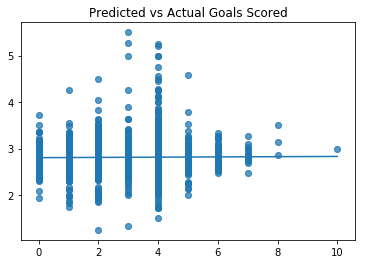

In [12]:
x = df_predicted_cleaned["Actual Score"]
y = df_predicted_cleaned["Predicted Score"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
#colors = np.random.rand()
#area = (abs(df_predicted_cleaned["Actual Score"] - df_predicted_cleaned["Predicted Score"]))
#plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.scatter(x, y, alpha=0.5)
plt.title("Predicted vs Actual Goals Scored")

plt.show()

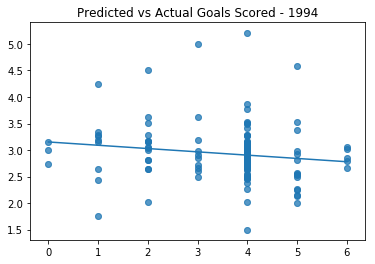

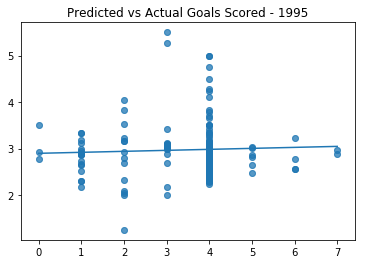

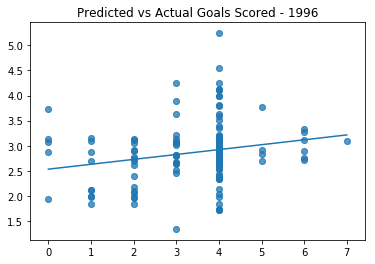

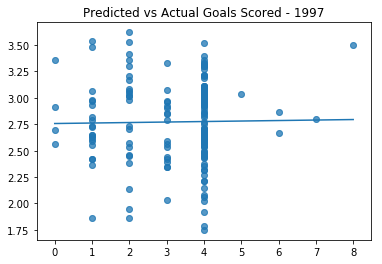

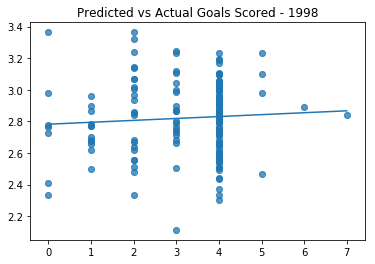

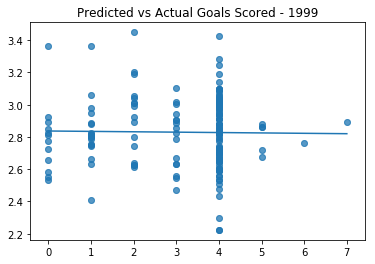

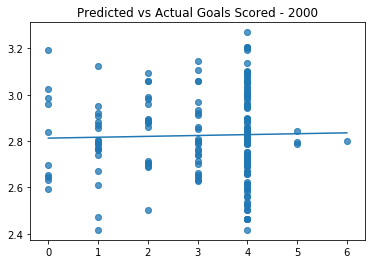

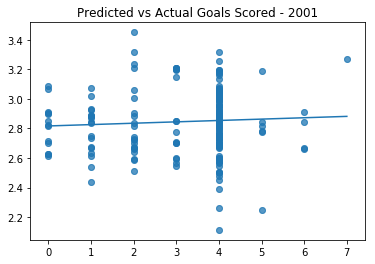

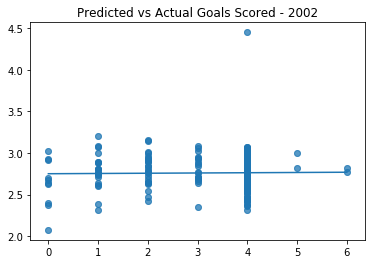

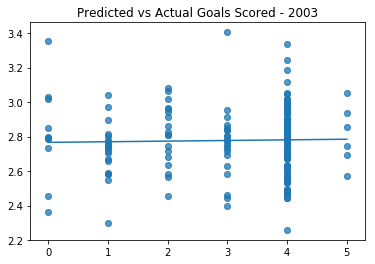

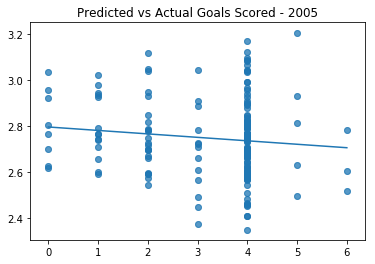

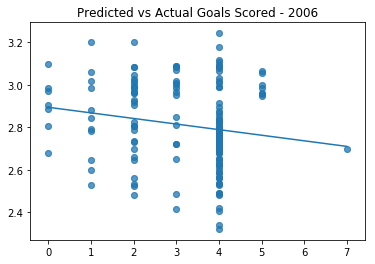

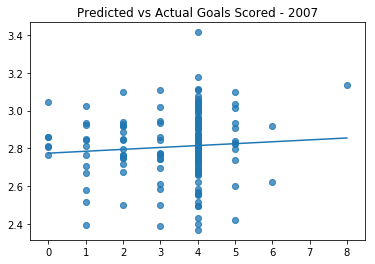

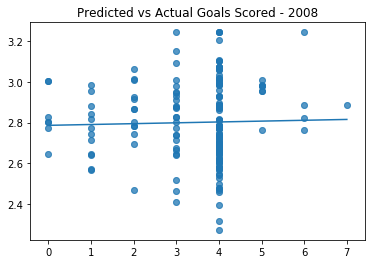

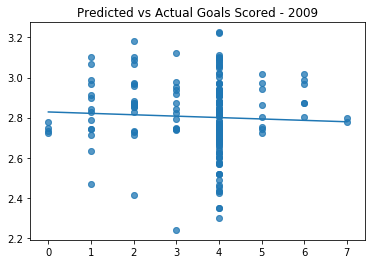

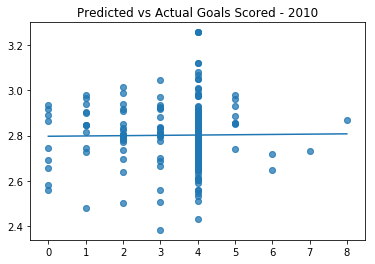

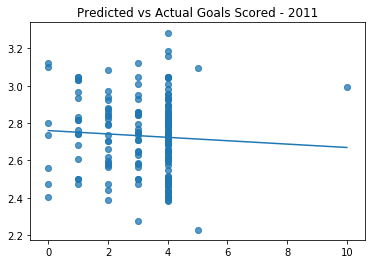

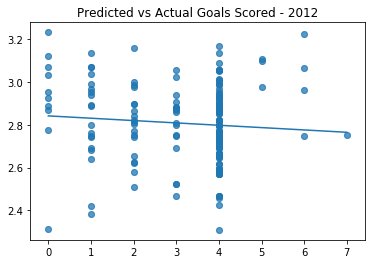

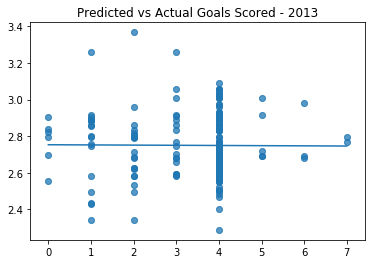

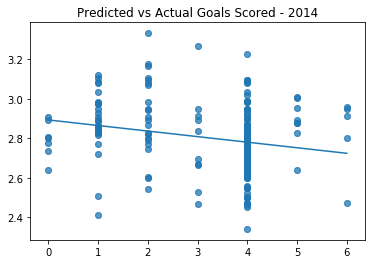

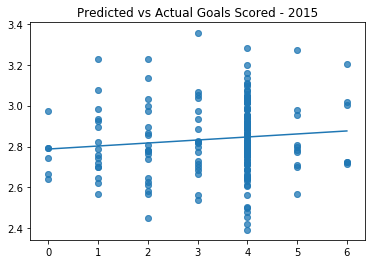

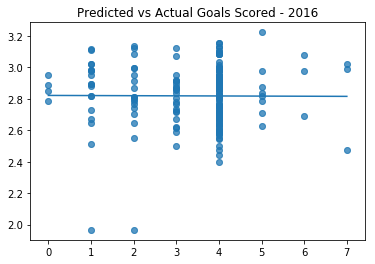

In [13]:
for i in range(1994, 2017):
    if i == 2004:
        continue
    
    x = df_predicted_cleaned["Actual Score"][i]
    y = df_predicted_cleaned["Predicted Score"][i]
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    #colors = np.random.rand()
    #area = (abs(df_predicted_cleaned["Actual Score"] - df_predicted_cleaned["Predicted Score"]))
    #plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.scatter(x, y, alpha=0.5)
    plt.title("Predicted vs Actual Goals Scored - {0}".format(i))

    plt.show()

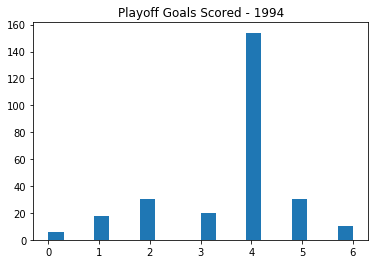

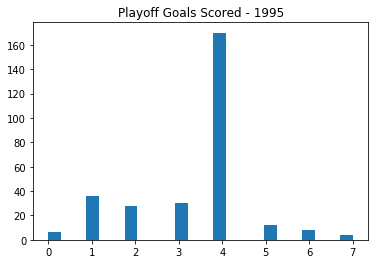

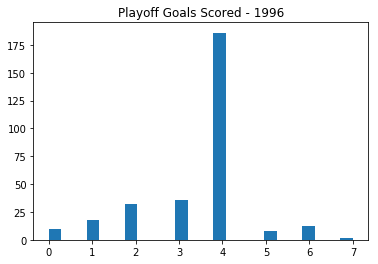

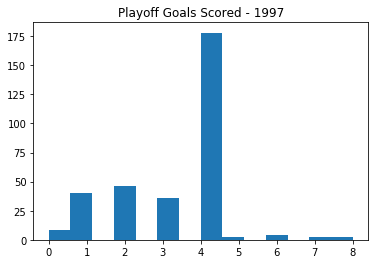

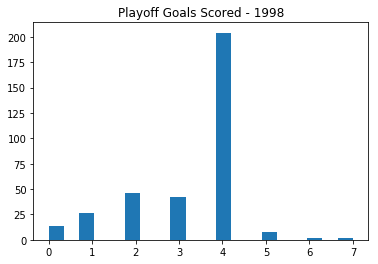

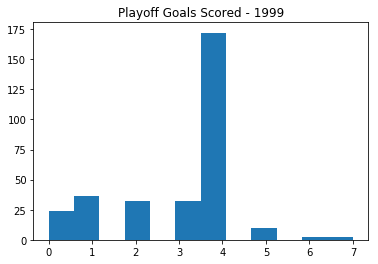

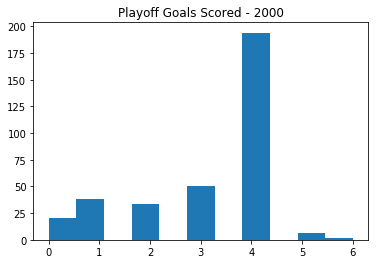

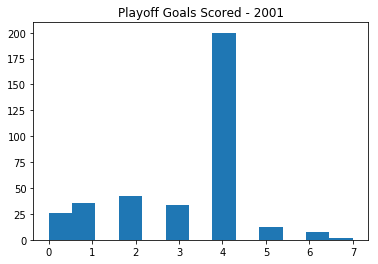

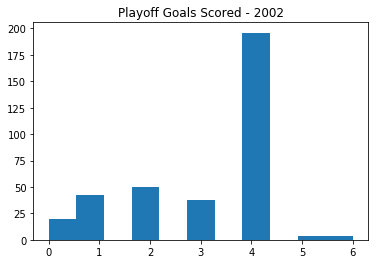

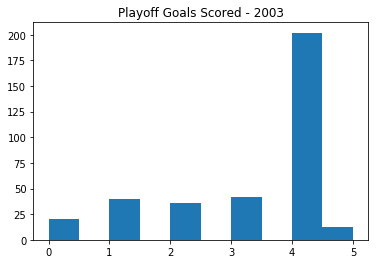

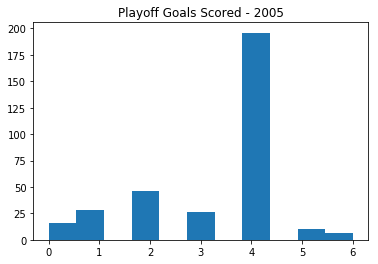

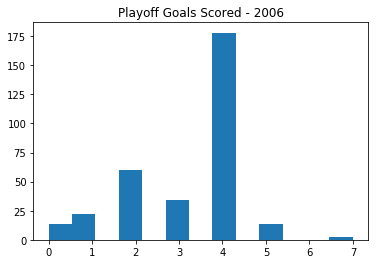

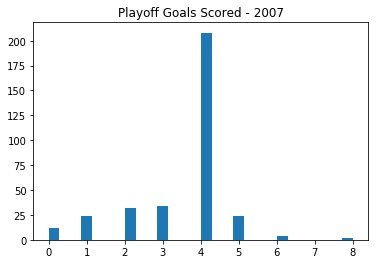

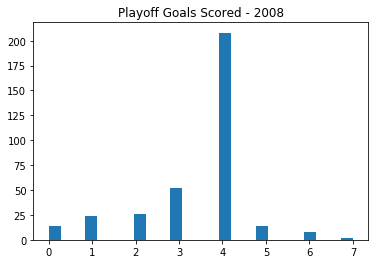

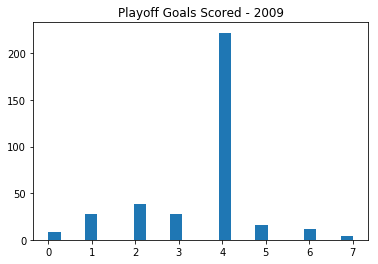

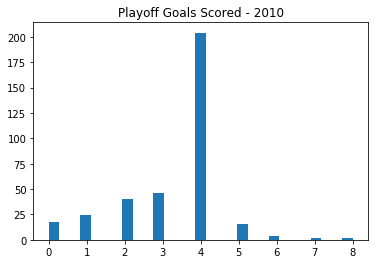

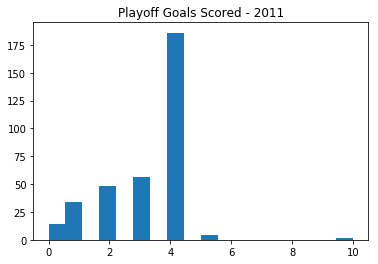

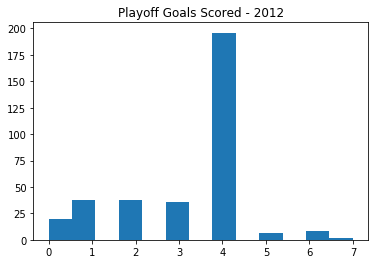

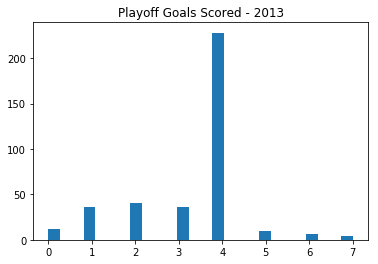

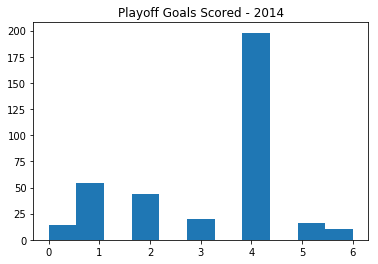

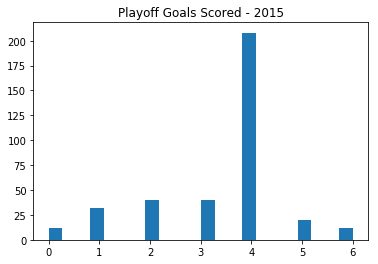

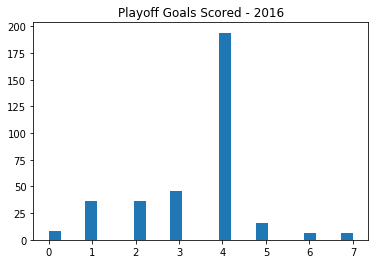

In [14]:
for i in range(1994, 2017):
    
    if i == 2004:
        continue
        
    rng = df_predicted_cleaned["Actual Score"][i]
    #a = np.hstack((rng.normal(size=1000), rng.normal(loc=5, scale=2, size=1000)))
    plt.hist(rng, bins="auto")  # arguments are passed to np.histogram
    plt.title("Playoff Goals Scored - {0}".format(i))
    plt.show()

In [15]:
#Analytics

actual = df_predicted_cleaned["Actual Score"]
predicted = df_predicted_cleaned["Predicted Score"]
stats.chisquare(actual,predicted)

Power_divergenceResult(statistic=5580.001260014135, pvalue=1.0)

In [17]:
for i in range(1994, 2017):
    
    if i == 2004:
        continue
        
    actual = df_predicted_cleaned["Actual Score"][i]
    predicted = df_predicted_cleaned["Predicted Score"][i]
    print(stats.chisquare(actual,predicted), "Season - {0}".format(i))

Power_divergenceResult(statistic=243.6469714395167, pvalue=0.8443691822647307) Season - 1994
Power_divergenceResult(statistic=236.88101086157846, pvalue=0.9930020034133721) Season - 1995
Power_divergenceResult(statistic=223.70940972778595, pvalue=0.9997897307345319) Season - 1996
Power_divergenceResult(statistic=247.78289652491907, pvalue=0.9984222802125039) Season - 1997
Power_divergenceResult(statistic=220.19098340241646, pvalue=0.9999999626109849) Season - 1998
Power_divergenceResult(statistic=247.54282970055067, pvalue=0.9957419085654087) Season - 1999
Power_divergenceResult(statistic=227.4746346917698, pvalue=0.9999997247407068) Season - 2000
Power_divergenceResult(statistic=287.45168613824546, pvalue=0.9977879008848085) Season - 2001
Power_divergenceResult(statistic=254.9067072953464, pvalue=0.9999771976446845) Season - 2002
Power_divergenceResult(statistic=244.38328835082064, pvalue=0.999996564602738) Season - 2003
Power_divergenceResult(statistic=250.5614422186693, pvalue=0.999

In [21]:
df_all.head()

Ref              Team  Actual Score
Year                                               
1994   Don Koharski  New York Rangers             4
1994   Don Koharski  Quebec Nordiques             5
1994     Swede Knox  New York Rangers             4
1994     Swede Knox  Quebec Nordiques             5
1994  Mark Faucette  New York Rangers             8

In [23]:
df_all_regular = pd.read_csv("all_data_cleaned.csv", index_col="Year")
df_all_regular.head()

Ref  Score                 Team
Year                                           
1994  Bill McCreary      2       Buffalo Sabres
1994  Bill McCreary      1     New York Rangers
1994  Kevin Collins      2       Buffalo Sabres
1994  Kevin Collins      1     New York Rangers
1994   Dave Jackson      5  Pittsburgh Penguins

In [25]:
df_all_regular["Score"].count()

105412

In [26]:
df_all_regular["Score"].sum()/df_all_regular["Score"].count()

2.7596668311008234

In [29]:
df_all["Actual Score"].sum()/df_all["Actual Score"].count()

2.6136004217185027

In [56]:
df_all_regular.tail()

Ref  Score               Team
Year                                           
2017  Francis Charron      2  Los Angeles Kings
2017     Eric Furlatt      6     Minnesota Wild
2017     Eric Furlatt      3    San Jose Sharks
2017  Tom Chmielewski      6     Minnesota Wild
2017  Tom Chmielewski      3    San Jose Sharks

In [62]:
df_all_regular.iloc[0]

Ref       Bill McCreary
Score                 2
Team     Buffalo Sabres
Name: 1994, dtype: object

In [70]:
df_all_regular.iloc[1][1]

1

In [76]:
i=0
if df_all_regular.iloc[i][1] > df_all_regular.iloc[1][1]:
    print(df_all_regular.iloc[i][2], "Win") 
    print(df_all_regular.iloc[i + 1][2], "Lose")

elif df_all_regular.iloc[i][1] == df_all_regular.iloc[1][1]:
    print(df_all_regular.iloc[i][2], "Tie") 
    print(df_all_regular.iloc[i + 1][2], "Tie")

else:
    print(df_all_regular.iloc[i + 1][2], "Win")
    print(df_all_regular.iloc[i][2], "Lose")


Buffalo Sabres Win
New York Rangers Lose


In [81]:
score1 = 7
score2 = 7
if score1 > score2:
    print(df_all_regular.iloc[i][2], "Win") 
    print(df_all_regular.iloc[i + 1][2], "Lose")

elif score1 == score2:
    print(df_all_regular.iloc[i][2], "Tie") 
    print(df_all_regular.iloc[i + 1][2], "Tie")

else:
    print(df_all_regular.iloc[i + 1][2], "Win")
    print(df_all_regular.iloc[i][2], "Lose")

Buffalo Sabres Tie
New York Rangers Tie


In [61]:
a = df_all_regular.index[i]
a

1994

In [84]:
x = []

for i in range(0, len(df_all_regular.index), 4):
 
        
    a = df_all_regular.index[i]
    Team1 = df_all_regular.iloc[i][2]
    Team2 = df_all_regular.iloc[i+1][2]
    ref1 = df_all_regular.iloc[i][0]
    ref2 = df_all_regular.iloc[i+2][0]
    score1 = df_all_regular.iloc[i][1]
    score2 = df_all_regular.iloc[i+1][1]
    
    if score1 > score2:
        e1 = "Win"
        e2 = "Loss"

    elif score1 == score2:
        e1 = "Tie" 
        e2 = "Tie"

    else:
        e1 = "Loss"
        e2 = "Win"
    
    x.append({"Year": a, "Ref": ref1, "Team": Team1, "Score": score1, "Outcome": e1})
    x.append({"Year": a, "Ref": ref2, "Team": Team1, "Score": score1, "Outcome": e1})
        
    x.append({"Year": a, "Ref": ref1, "Team": Team2, "Score": score2, "Outcome": e2})
    x.append({"Year": a, "Ref": ref2, "Team": Team2, "Score": score2, "Outcome": e2})
      
df_win_loss = pd.DataFrame(x)
df_win_loss = df_win_loss.set_index("Year")
df_win_loss = df_win_loss[['Ref', 'Team', 'Score', "Outcome"]]
df_win_loss.to_csv("regular_season_win_loss.csv")
df_win_loss.tail()

Ref               Team  Score Outcome
Year                                                   
2017  Francis Charron  Los Angeles Kings      2    Loss
2017     Eric Furlatt     Minnesota Wild      6     Win
2017  Tom Chmielewski     Minnesota Wild      6     Win
2017     Eric Furlatt    San Jose Sharks      3    Loss
2017  Tom Chmielewski    San Jose Sharks      3    Loss

In [86]:
df_win_loss.head()

Ref                 Team  Score Outcome
Year                                                   
1994  Bill McCreary       Buffalo Sabres      2     Win
1994  Kevin Collins       Buffalo Sabres      2     Win
1994  Bill McCreary     New York Rangers      1    Loss
1994  Kevin Collins     New York Rangers      1    Loss
1994   Dave Jackson  Pittsburgh Penguins      5     Win

In [ ]:
a = df.loc[((df["Ref"] == i) & (df["Team"] == j)), "Score"].sum() / df.loc[((df["Ref"] == i) & (df["Team"] == j)), "Score"].count()

In [95]:
a = df.loc[((df_win_loss["Ref"] == ["Bill McCreary"]) & (df_win_loss["Team"] == "Buffalo Sabres") & (df_win_loss["Outcome"] == "Win")), "Outcome" ].count()
a

ValueError: Arrays were different lengths: 105412 vs 1

In [96]:
e = []

for i in df_win_loss.Ref.unique():
    for j in df_win_loss.Team.unique():
        a = df_win_loss.loc[((df_win_loss["Ref"] == i) & (df_win_loss["Team"] == j) & (df_win_loss["Outcome"] == "Win")), "Outcome" ].count()
        b = df_win_loss.loc[((df_win_loss["Ref"] == i) & (df_win_loss["Team"] == j) & (df_win_loss["Outcome"] == "Loss")), "Outcome" ].count()
        c = a/(a+b)
        e.append({"Ref": i, "Team": j, "Wins": a, "Losses": b, "Win %": c})

regular_season_win_loss_record = pd.DataFrame(e)       

regular_season_win_loss_record = regular_season_win_loss_record[['Ref', 'Team', 'Wins', "Losses", "Win %"]]

regular_season_win_loss_record.to_csv("regular_season_win_loss_record.csv")

C:\Users\rbosshard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


In [89]:
regular_season_win_loss_record = regular_season_win_loss_record[['Ref', 'Team', 'Wins', "Losses", "Win %"]]

regular_season_win_loss_record.to_csv("regular_season_win_loss_record.csv")

In [97]:
regular_season_win_loss_record.head()

Ref                 Team  Wins  Losses     Win %
0  Bill McCreary       Buffalo Sabres    52      35  0.597701
1  Bill McCreary     New York Rangers    38      53  0.417582
2  Bill McCreary  Pittsburgh Penguins    31      35  0.469697
3  Bill McCreary  Tampa Bay Lightning    21      32  0.396226
4  Bill McCreary   Chicago Blackhawks    24      41  0.369231

In [98]:
goals_per_game = pd.read_csv("goals_per_game.csv", index_col="Unnamed: 0")
goals_per_game.head()

Ref                 Team  Goals per Game
0  Bill McCreary       Buffalo Sabres        2.990000
1  Bill McCreary     New York Rangers        2.447619
2  Bill McCreary  Pittsburgh Penguins        2.720000
3  Bill McCreary  Tampa Bay Lightning        2.571429
4  Bill McCreary   Chicago Blackhawks        2.500000

In [99]:
regular_season_win_loss_record.tail()

Ref                   Team  Wins  Losses  Win %
13567  Corey Syvret         Minnesota Wild     0       0    NaN
13568  Corey Syvret  Columbus Blue Jackets     0       0    NaN
13569  Corey Syvret          Winnipeg Jets     0       0    NaN
13570  Corey Syvret        Arizona Coyotes     0       0    NaN
13571  Corey Syvret   Vegas Golden Knights     0       0    NaN

In [101]:
goals_per_game.tail()

Ref                   Team  Goals per Game
13567  Corey Syvret         Minnesota Wild             NaN
13568  Corey Syvret  Columbus Blue Jackets             NaN
13569  Corey Syvret          Winnipeg Jets             NaN
13570  Corey Syvret        Arizona Coyotes             NaN
13571  Corey Syvret   Vegas Golden Knights             NaN

In [102]:
regular_season_win_loss_record["Goals per Game"] = goals_per_game["Goals per Game"]
regular_season_win_loss_record.head()

Ref                 Team  Wins  Losses     Win %  Goals per Game
0  Bill McCreary       Buffalo Sabres    52      35  0.597701        2.990000
1  Bill McCreary     New York Rangers    38      53  0.417582        2.447619
2  Bill McCreary  Pittsburgh Penguins    31      35  0.469697        2.720000
3  Bill McCreary  Tampa Bay Lightning    21      32  0.396226        2.571429
4  Bill McCreary   Chicago Blackhawks    24      41  0.369231        2.500000

In [103]:
regular_season_win_loss_record.to_csv("regular_season_ref_data.csv")

In [3]:
df_ref = pd.read_csv("regular_season_ref_data.csv", index_col="Unnamed: 0")

In [4]:
df_ref.head()

Ref                 Team  Wins  Losses     Win %  Goals per Game
0  Bill McCreary       Buffalo Sabres    52      35  0.597701        2.990000
1  Bill McCreary     New York Rangers    38      53  0.417582        2.447619
2  Bill McCreary  Pittsburgh Penguins    31      35  0.469697        2.720000
3  Bill McCreary  Tampa Bay Lightning    21      32  0.396226        2.571429
4  Bill McCreary   Chicago Blackhawks    24      41  0.369231        2.500000

In [125]:
df = pd.read_csv("2017_data.csv", index_col="code")
df.head()

home_team  home_score            away_team  away_score  \
code                                                                           
2017020001        Winnipeg Jets           2  Toronto Maple Leafs           7   
2017020002  Pittsburgh Penguins           4      St. Louis Blues           5   
2017020003      Edmonton Oilers           3       Calgary Flames           0   
2017020004      San Jose Sharks           3  Philadelphia Flyers           5   
2017020005        Boston Bruins           4  Nashville Predators           3   

                 official_1        official_2               winner  \
code                                                                 
2017020001         Tim Peel  Graham Skilliter  Toronto Maple Leafs   
2017020002    Trevor Hanson    Marc Joannette      St. Louis Blues   
2017020003     Dave Jackson        Jake Brenk      Edmonton Oilers   
2017020004      Jon McIsaac     Kevin Pollock  Philadelphia Flyers   
2017020005  Francis Charron  Kelly Sutherland        Boston Bruins   

                          loser  
code                             
2017020001        Winnipeg Jets  
2017020002  Pittsburgh Penguins  
2017020003       Calgary Flames  
2017020004      San Jose Sharks  
2017020005  Nashville Predators

In [124]:
df1 = pd.read_csv("2016_data.csv", index_col="code")
df1.head()

home_team  home_score            away_team  away_score  \
code                                                                          
2016020001     Ottawa Senators           5  Toronto Maple Leafs           4   
2016020002  Chicago Blackhawks           2      St. Louis Blues           5   
2016020003     Edmonton Oilers           7       Calgary Flames           4   
2016020004     San Jose Sharks           2    Los Angeles Kings           1   
2016020005      Buffalo Sabres           1   Montréal Canadiens           4   

                    official_1        official_2              winner  \
code                                                                   
2016020001        Wes McCauley   Francis Charron     Ottawa Senators   
2016020002         Jon McIsaac         Ian Walsh     St. Louis Blues   
2016020003      Brian Pochmara       Kyle Rehman     Edmonton Oilers   
2016020004  Justin St. Pierre   Graham Skilliter     San Jose Sharks   
2016020005        Dan O'Rourke       Jean Hebert  Montréal Canadiens   

                          loser  
code                             
2016020001  Toronto Maple Leafs  
2016020002   Chicago Blackhawks  
2016020003       Calgary Flames  
2016020004    Los Angeles Kings  
2016020005       Buffalo Sabres

In [127]:
df_total = df.append(df1)
df_total.tail()

home_team  home_score            away_team  away_score  \
code                                                                           
2016021226     New York Rangers           3  Pittsburgh Penguins           2   
2016021227  Philadelphia Flyers           3  Carolina Hurricanes           3   
2016021228  Washington Capitals           0     Florida Panthers           2   
2016021229        Anaheim Ducks           4    Los Angeles Kings           3   
2016021230      Edmonton Oilers           5    Vancouver Canucks           2   

                     official_1      official_2               winner  \
code                                                                   
2016021226      Francis Charron  Dan O'Halloran     New York Rangers   
2016021227  Thomas John Luxmore    Eric Furlatt  Philadelphia Flyers   
2016021228         Wes McCauley    Garrett Rank     Florida Panthers   
2016021229   Justin St. Pierre    Kevin Pollock        Anaheim Ducks   
2016021230           Gord Dwyer     Dean Morton      Edmonton Oilers   

                          loser  
code                             
2016021226  Pittsburgh Penguins  
2016021227  Carolina Hurricanes  
2016021228  Washington Capitals  
2016021229    Los Angeles Kings  
2016021230    Vancouver Canucks

In [120]:
df["home_outcome"] = np.where(df['home_score'] > df['away_score'], 1, 0)
df.head()                                

home_team  home_score            away_team  away_score  \
code                                                                           
2017020001        Winnipeg Jets           2  Toronto Maple Leafs           7   
2017020002  Pittsburgh Penguins           4      St. Louis Blues           5   
2017020003      Edmonton Oilers           3       Calgary Flames           0   
2017020004      San Jose Sharks           3  Philadelphia Flyers           5   
2017020005        Boston Bruins           4  Nashville Predators           3   

                 official_1        official_2               winner  \
code                                                                 
2017020001         Tim Peel  Graham Skilliter  Toronto Maple Leafs   
2017020002    Trevor Hanson    Marc Joannette      St. Louis Blues   
2017020003     Dave Jackson        Jake Brenk      Edmonton Oilers   
2017020004      Jon McIsaac     Kevin Pollock  Philadelphia Flyers   
2017020005  Francis Charron  Kelly Sutherland        Boston Bruins   

                          loser  home_outcome  
code                                           
2017020001        Winnipeg Jets             0  
2017020002  Pittsburgh Penguins             0  
2017020003       Calgary Flames             1  
2017020004      San Jose Sharks             0  
2017020005  Nashville Predators             1

In [122]:
df["away_outcome"] = np.where(df['home_score'] < df['away_score'], 1, 0)
df.head()  

home_team  home_score            away_team  away_score  \
code                                                                           
2017020001        Winnipeg Jets           2  Toronto Maple Leafs           7   
2017020002  Pittsburgh Penguins           4      St. Louis Blues           5   
2017020003      Edmonton Oilers           3       Calgary Flames           0   
2017020004      San Jose Sharks           3  Philadelphia Flyers           5   
2017020005        Boston Bruins           4  Nashville Predators           3   

                 official_1        official_2               winner  \
code                                                                 
2017020001         Tim Peel  Graham Skilliter  Toronto Maple Leafs   
2017020002    Trevor Hanson    Marc Joannette      St. Louis Blues   
2017020003     Dave Jackson        Jake Brenk      Edmonton Oilers   
2017020004      Jon McIsaac     Kevin Pollock  Philadelphia Flyers   
2017020005  Francis Charron  Kelly Sutherland        Boston Bruins   

                          loser  home_outcome  away_outcome  
code                                                         
2017020001        Winnipeg Jets             0             1  
2017020002  Pittsburgh Penguins             0             1  
2017020003       Calgary Flames             1             0  
2017020004      San Jose Sharks             0             1  
2017020005  Nashville Predators             1             0

In [128]:
df_total=pd.DataFrame()
for i in range(1994, 2017):
    if i == 2004:
        continue
    file_name = "{0}_data.csv".format(i)
    df = pd.read_csv(file_name, index_col="code")
    df_total = df_total.append(df)
save_file_name = "all_data.csv"
df_total.to_csv(save_file_name)

In [129]:
df_total.head()

home_team  home_score            away_team  away_score  \
code                                                                            
1994020001      New York Rangers           1       Buffalo Sabres           2   
1994020002   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
1994020003     Detroit Red Wings           4   Chicago Blackhawks           1   
1994020004  Winnipeg Jets (1979)           3       Calgary Flames           3   
1994020005       Edmonton Oilers           2        Anaheim Ducks           1   

                  official_1       official_2                winner  \
code                                                                  
1994020001     Bill McCreary    Kevin Collins        Buffalo Sabres   
1994020002      Dave Jackson  Gordon Broseker   Pittsburgh Penguins   
1994020003          Faucette      G. Devorski     Detroit Red Wings   
1994020004      Kerry Fraser        Mike Cvik  Winnipeg Jets (1979)   
1994020005  Richard Trottier     Andy McElman       Edmonton Oilers   

                          loser  
code                             
1994020001     New York Rangers  
1994020002  Tampa Bay Lightning  
1994020003   Chicago Blackhawks  
1994020004       Calgary Flames  
1994020005        Anaheim Ducks

In [130]:
df_total["home_outcome"] = np.where(df_total['home_score'] > df_total['away_score'], 1, 0)
df_total["away_outcome"] = np.where(df_total['home_score'] < df_total['away_score'], 1, 0)
df_total.head()

home_team  home_score            away_team  away_score  \
code                                                                            
1994020001      New York Rangers           1       Buffalo Sabres           2   
1994020002   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
1994020003     Detroit Red Wings           4   Chicago Blackhawks           1   
1994020004  Winnipeg Jets (1979)           3       Calgary Flames           3   
1994020005       Edmonton Oilers           2        Anaheim Ducks           1   

                  official_1       official_2                winner  \
code                                                                  
1994020001     Bill McCreary    Kevin Collins        Buffalo Sabres   
1994020002      Dave Jackson  Gordon Broseker   Pittsburgh Penguins   
1994020003          Faucette      G. Devorski     Detroit Red Wings   
1994020004      Kerry Fraser        Mike Cvik  Winnipeg Jets (1979)   
1994020005  Richard Trottier     Andy McElman       Edmonton Oilers   

                          loser  home_outcome  away_outcome  
code                                                         
1994020001     New York Rangers             0             1  
1994020002  Tampa Bay Lightning             0             1  
1994020003   Chicago Blackhawks             1             0  
1994020004       Calgary Flames             0             0  
1994020005        Anaheim Ducks             1             0

In [132]:
df_total=df_total.drop(['winner', 'loser'], axis=1)
df_total.head()

home_team  home_score            away_team  away_score  \
code                                                                            
1994020001      New York Rangers           1       Buffalo Sabres           2   
1994020002   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
1994020003     Detroit Red Wings           4   Chicago Blackhawks           1   
1994020004  Winnipeg Jets (1979)           3       Calgary Flames           3   
1994020005       Edmonton Oilers           2        Anaheim Ducks           1   

                  official_1       official_2  home_outcome  away_outcome  
code                                                                       
1994020001     Bill McCreary    Kevin Collins             0             1  
1994020002      Dave Jackson  Gordon Broseker             0             1  
1994020003          Faucette      G. Devorski             1             0  
1994020004      Kerry Fraser        Mike Cvik             0             0  
1994020005  Richard Trottier     Andy McElman             1             0

In [133]:
df_total.to_csv("all_data_outcome.csv")

In [2]:
df_total=pd.read_csv("all_data_outcome.csv", index_col="code")
df_total.head()

home_team  home_score            away_team  away_score  \
code                                                                            
1994020001      New York Rangers           1       Buffalo Sabres           2   
1994020002   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
1994020003     Detroit Red Wings           4   Chicago Blackhawks           1   
1994020004  Winnipeg Jets (1979)           3       Calgary Flames           3   
1994020005       Edmonton Oilers           2        Anaheim Ducks           1   

                  official_1       official_2  home_outcome  away_outcome  
code                                                                       
1994020001     Bill McCreary    Kevin Collins             0             1  
1994020002      Dave Jackson  Gordon Broseker             0             1  
1994020003          Faucette      G. Devorski             1             0  
1994020004      Kerry Fraser        Mike Cvik             0             0  
1994020005  Richard Trottier     Andy McElman             1             0

In [137]:
df_ref.head()

Ref                 Team  Wins  Losses     Win %  Goals per Game
0  Bill McCreary       Buffalo Sabres    52      35  0.597701        2.990000
1  Bill McCreary     New York Rangers    38      53  0.417582        2.447619
2  Bill McCreary  Pittsburgh Penguins    31      35  0.469697        2.720000
3  Bill McCreary  Tampa Bay Lightning    21      32  0.396226        2.571429
4  Bill McCreary   Chicago Blackhawks    24      41  0.369231        2.500000

In [142]:
df_ref["Win %"].loc[(df_ref["Ref"]=="Bill McCreary") & (df_ref["Team"] == "Buffalo Sabres")][0]

0.5977011494252874

In [5]:
df_ref.head()

Ref                 Team  Wins  Losses     Win %  Goals per Game
0  Bill McCreary       Buffalo Sabres    52      35  0.597701        2.990000
1  Bill McCreary     New York Rangers    38      53  0.417582        2.447619
2  Bill McCreary  Pittsburgh Penguins    31      35  0.469697        2.720000
3  Bill McCreary  Tampa Bay Lightning    21      32  0.396226        2.571429
4  Bill McCreary   Chicago Blackhawks    24      41  0.369231        2.500000

In [13]:
df_merge=pd.merge(df_total, df_ref, how='left', left_on=['official_1', "home_team"], right_on=['Ref', "Team"])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

                Ref                  Team  Wins  Losses     Win %  \
0     Bill McCreary      New York Rangers    38      53  0.417582   
1      Dave Jackson   Tampa Bay Lightning    47      47  0.500000   
2          Faucette     Detroit Red Wings     4       1  0.800000   
3      Kerry Fraser  Winnipeg Jets (1979)     0       2  0.000000   
4  Richard Trottier       Edmonton Oilers    15       7  0.681818   

   Goals per Game  
0        2.447619  
1        2.742857  
2        2.571429  
3        2.200000  
4        2.962963

In [156]:
list(df_merge)

['home_team',
 'home_score',
 'away_team',
 'away_score',
 'official_1',
 'official_2',
 'home_outcome',
 'away_outcome',
 'Ref',
 'Team',
 'Wins',
 'Losses',
 'Win %',
 'Goals per Game']

In [14]:
df_merge.columns = ['home_team', 'home_score', 'away_team',  'away_score',  'official_1',
 'official_2',
 'home_outcome',
 'away_outcome',
 'Ref',
 'Team',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg']

In [15]:
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

                Ref                  Team  home_official_1_wins  \
0     Bill McCreary      New York Rangers                    38   
1      Dave Jackson   Tampa Bay Lightning                    47   
2          Faucette     Detroit Red Wings                     4   
3      Kerry Fraser  Winnipeg Jets (1979)                     0   
4  Richard Trottier       Edmonton Oilers                    15   

   home_official_1_losses  home_official_1_win_%  home_official_1_gpg  
0                      53               0.417582             2.447619  
1                      47               0.500000             2.742857  
2                       1               0.800000             2.571429  
3                       2               0.000000             2.200000  
4                       7               0.681818             2.962963

In [16]:
df_merge=df_merge.drop(columns=['Ref', 'Team'])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg  
0             2.447619  
1             2.742857  
2             2.571429  
3             2.200000  
4             2.962963

In [17]:
df_merge=pd.merge(df_merge, df_ref, how='left', left_on=['official_2', "home_team"], right_on=['Ref', "Team"])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg              Ref                  Team  Wins  Losses  \
0             2.447619    Kevin Collins      New York Rangers    20      21   
1             2.742857  Gordon Broseker   Tampa Bay Lightning    10      17   
2             2.571429      G. Devorski     Detroit Red Wings     3       0   
3             2.200000        Mike Cvik  Winnipeg Jets (1979)     5       4   
4             2.962963     Andy McElman       Edmonton Oilers     5       5   

      Win %  Goals per Game  
0  0.487805        2.895833  
1  0.370370        2.771429  
2  1.000000        5.250000  
3  0.555556        3.500000  
4  0.500000        2.500000

In [19]:
df_merge.columns = ['home_team', 'home_score', 'away_team',  'away_score',  'official_1',
 'official_2',
 'home_outcome',
 'away_outcome',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'Ref',
 'Team',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg']
df_merge=df_merge.drop(columns=['Ref', 'Team'])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg  home_official_2_wins  home_official_2_losses  \
0             2.447619                    20                      21   
1             2.742857                    10                      17   
2             2.571429                     3                       0   
3             2.200000                     5                       4   
4             2.962963                     5                       5   

   home_official_2_win_%  home_official_2_gpg  
0               0.487805             2.895833  
1               0.370370             2.771429  
2               1.000000             5.250000  
3               0.555556             3.500000  
4               0.500000             2.500000

In [12]:
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses       ...         Wins_x  \
0                    38                      53       ...             20   
1                    47                      47       ...             10   
2                     4                       1       ...              3   
3                     0                       2       ...              5   
4                    15                       7       ...              5   

   Losses_x   Win %_x Goals per Game_x            Ref_y                Team_y  \
0        21  0.487805         2.895833    Kevin Collins      New York Rangers   
1        17  0.370370         2.771429  Gordon Broseker   Tampa Bay Lightning   
2         0  1.000000         5.250000      G. Devorski     Detroit Red Wings   
3         4  0.555556         3.500000        Mike Cvik  Winnipeg Jets (1979)   
4         5  0.500000         2.500000     Andy McElman       Edmonton Oilers   

   Wins_y  Losses_y   Win %_y Goals per Game_y  
0      20        21  0.487805         2.895833  
1      10        17  0.370370         2.771429  
2       3         0  1.000000         5.250000  
3       5         4  0.555556         3.500000  
4       5         5  0.500000         2.500000  

[5 rows x 24 columns]

In [20]:
df_merge=pd.merge(df_merge, df_ref, how='left', left_on=['official_1', "away_team"], right_on=['Ref', "Team"])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses       ...        \
0                    38                      53       ...         
1                    47                      47       ...         
2                     4                       1       ...         
3                     0                       2       ...         
4                    15                       7       ...         

   home_official_2_wins  home_official_2_losses  home_official_2_win_%  \
0                    20                      21               0.487805   
1                    10                      17               0.370370   
2                     3                       0               1.000000   
3                     5                       4               0.555556   
4                     5                       5               0.500000   

   home_official_2_gpg               Ref                 Team Wins Losses  \
0             2.895833     Bill McCreary       Buffalo Sabres   52     35   
1             2.771429      Dave Jackson  Pittsburgh Penguins   39     38   
2             5.250000          Faucette   Chicago Blackhawks    1      3   
3             3.500000      Kerry Fraser       Calgary Flames   20     29   
4             2.500000  Richard Trottier        Anaheim Ducks   15     17   

      Win %  Goals per Game  
0  0.597701        2.990000  
1  0.506494        2.988095  
2  0.250000        1.250000  
3  0.408163        2.491228  
4  0.468750        2.617647  

[5 rows x 22 columns]

In [22]:
df_merge.columns = ['home_team', 'home_score', 'away_team',  'away_score',  'official_1',
 'official_2',
 'home_outcome',
 'away_outcome',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg']
#df_merge=df_merge.drop(columns=['Ref', 'Team'])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg  home_official_2_wins  home_official_2_losses  \
0             2.447619                    20                      21   
1             2.742857                    10                      17   
2             2.571429                     3                       0   
3             2.200000                     5                       4   
4             2.962963                     5                       5   

   home_official_2_win_%  home_official_2_gpg  away_official_1_wins  \
0               0.487805             2.895833                    52   
1               0.370370             2.771429                    39   
2               1.000000             5.250000                     1   
3               0.555556             3.500000                    20   
4               0.500000             2.500000                    15   

   away_official_1_losses  away_official_1_win_%  away_official_1_gpg  
0                      35               0.597701             2.990000  
1                      38               0.506494             2.988095  
2                       3               0.250000             1.250000  
3                      29               0.408163             2.491228  
4                      17               0.468750             2.617647

In [23]:
df_merge=pd.merge(df_merge, df_ref, how='left', left_on=['official_2', "away_team"], right_on=['Ref', "Team"])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses       ...        \
0                    38                      53       ...         
1                    47                      47       ...         
2                     4                       1       ...         
3                     0                       2       ...         
4                    15                       7       ...         

   away_official_1_wins  away_official_1_losses  away_official_1_win_%  \
0                    52                      35               0.597701   
1                    39                      38               0.506494   
2                     1                       3               0.250000   
3                    20                      29               0.408163   
4                    15                      17               0.468750   

   away_official_1_gpg              Ref                 Team  Wins  Losses  \
0             2.990000    Kevin Collins       Buffalo Sabres     8       8   
1             2.988095  Gordon Broseker  Pittsburgh Penguins    18       8   
2             1.250000      G. Devorski   Chicago Blackhawks     0       1   
3             2.491228        Mike Cvik       Calgary Flames    19      25   
4             2.617647     Andy McElman        Anaheim Ducks     4       3   

      Win %  Goals per Game  
0  0.500000        2.285714  
1  0.692308        3.642857  
2  0.000000        1.000000  
3  0.431818        2.580000  
4  0.571429        3.428571  

[5 rows x 26 columns]

In [24]:
df_merge.columns = ['home_team', 'home_score', 'away_team',  'away_score',  'official_1',
 'official_2',
 'home_outcome',
 'away_outcome',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 "Ref",  
 "Team", 
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']
df_merge=df_merge.drop(columns=['Ref', 'Team'])
df_merge.head()

home_team  home_score            away_team  away_score  \
0      New York Rangers           1       Buffalo Sabres           2   
1   Tampa Bay Lightning           3  Pittsburgh Penguins           5   
2     Detroit Red Wings           4   Chicago Blackhawks           1   
3  Winnipeg Jets (1979)           3       Calgary Flames           3   
4       Edmonton Oilers           2        Anaheim Ducks           1   

         official_1       official_2  home_outcome  away_outcome  \
0     Bill McCreary    Kevin Collins             0             1   
1      Dave Jackson  Gordon Broseker             0             1   
2          Faucette      G. Devorski             1             0   
3      Kerry Fraser        Mike Cvik             0             0   
4  Richard Trottier     Andy McElman             1             0   

   home_official_1_wins  home_official_1_losses         ...           \
0                    38                      53         ...            
1                    47                      47         ...            
2                     4                       1         ...            
3                     0                       2         ...            
4                    15                       7         ...            

   home_official_2_win_%  home_official_2_gpg  away_official_1_wins  \
0               0.487805             2.895833                    52   
1               0.370370             2.771429                    39   
2               1.000000             5.250000                     1   
3               0.555556             3.500000                    20   
4               0.500000             2.500000                    15   

   away_official_1_losses  away_official_1_win_%  away_official_1_gpg  \
0                      35               0.597701             2.990000   
1                      38               0.506494             2.988095   
2                       3               0.250000             1.250000   
3                      29               0.408163             2.491228   
4                      17               0.468750             2.617647   

   away_official_2_wins  away_official_2_losses  away_official_2_win_%  \
0                     8                       8               0.500000   
1                    18                       8               0.692308   
2                     0                       1               0.000000   
3                    19                      25               0.431818   
4                     4                       3               0.571429   

   away_official_2_gpg  
0             2.285714  
1             3.642857  
2             1.000000  
3             2.580000  
4             3.428571  

[5 rows x 24 columns]

In [25]:
df_merge.to_csv("all_data_with_ref_stats.csv")

In [38]:
df = pd.read_csv("all_data_with_ref_stats.csv", index_col = "Unnamed: 0")
df

home_team  home_score              away_team  away_score  \
0          New York Rangers           1         Buffalo Sabres           2   
1       Tampa Bay Lightning           3    Pittsburgh Penguins           5   
2         Detroit Red Wings           4     Chicago Blackhawks           1   
3      Winnipeg Jets (1979)           3         Calgary Flames           3   
4           Edmonton Oilers           2          Anaheim Ducks           1   
5         Vancouver Canucks           1           Dallas Stars           1   
6           San Jose Sharks           2        St. Louis Blues           5   
7         Los Angeles Kings           3    Toronto Maple Leafs           3   
8          Hartford Whalers           1    Washington Capitals           1   
9        New York Islanders           2       Florida Panthers           1   
10         New York Rangers           5     Montréal Canadiens           2   
11      Philadelphia Flyers           1       Quebec Nordiques           3   
12     Winnipeg Jets (1979)           3          Anaheim Ducks           4   
13        Vancouver Canucks           1        St. Louis Blues           7   
14          San Jose Sharks           3    Toronto Maple Leafs           2   
15            Boston Bruins           4    Philadelphia Flyers           1   
16         Hartford Whalers           2      New Jersey Devils           2   
17       New York Islanders           3        Ottawa Senators           3   
18      Tampa Bay Lightning           2         Buffalo Sabres           5   
19        Detroit Red Wings           1         Calgary Flames           4   
20        Los Angeles Kings           3        Edmonton Oilers           4   
21         New York Rangers           1          Boston Bruins           2   
22         Florida Panthers           5    Pittsburgh Penguins           6   
23     Winnipeg Jets (1979)           5     Chicago Blackhawks           3   
24            Anaheim Ducks           5        Edmonton Oilers           4   
25         Quebec Nordiques           5    Washington Capitals           1   
26       New York Islanders           4    Philadelphia Flyers           3   
27        Detroit Red Wings           6      Vancouver Canucks           3   
28           Calgary Flames           6        St. Louis Blues           4   
29        Los Angeles Kings           2           Dallas Stars           4   
...                     ...         ...                    ...         ...   
25053    Colorado Avalanche           3         Minnesota Wild           4   
25054       Arizona Coyotes           4      Vancouver Canucks           3   
25055         Anaheim Ducks           4     Chicago Blackhawks           0   
25056     Los Angeles Kings           1         Calgary Flames           4   
25057       San Jose Sharks           2        Edmonton Oilers           4   
25058    Montréal Canadiens           2    Tampa Bay Lightning           4   
25059       Ottawa Senators           3       New York Rangers           1   
25060   Philadelphia Flyers           4  Columbus Blue Jackets           2   
25061         Boston Bruins           1    Washington Capitals           3   
25062     New Jersey Devils           2     New York Islanders           4   
25063   Toronto Maple Leafs           5    Pittsburgh Penguins           3   
25064     Detroit Red Wings           2     Montréal Canadiens           3   
25065      Florida Panthers           3         Buffalo Sabres           0   
25066   Carolina Hurricanes           4        St. Louis Blues           4   
25067         Winnipeg Jets           2    Nashville Predators           1   
25068          Dallas Stars           3     Colorado Avalanche           3   
25069       Arizona Coyotes           1         Minnesota Wild           3   
25070     Vancouver Canucks           2        Edmonton Oilers           3   
25071       San Jose Sharks           3         Calgary Flames           1   
25072     Los Angeles Kings           3 

In [35]:
list(df)

['home_team',
 'home_score',
 'away_team',
 'away_score',
 'official_1',
 'official_2',
 'home_outcome',
 'away_outcome',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']

In [108]:
lgrg = linear_model.LogisticRegression(solver='newton-cg')
X_home = df[['home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']]
Y_home = df['home_outcome']
lgrg.fit(X_home,Y_home)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
lgrg = linear_model.LogisticRegression(solver='newton-cg')
X_away = df[['home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']]
Y_away = df['away_outcome']
lgrg.fit(X_away,Y_away)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
lgrg.coef_[0][6]

2.9424517829606915

In [56]:
coef =  df[['home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']]

In [58]:
coef = list(coef)

In [59]:
coef

['home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']

In [141]:
coeff_away = []
for i in range(0,len(coef)):
    a = "{0}_coeff".format(coef[i])
    b = lgrg.coef_[0][i]
    coeff_away.append({"Coeff_Away": a, "Value": b})       
coeff_away = pd.DataFrame(coeff_away)

In [142]:
coeff_away.head()

Coeff_Away     Value
0    home_official_1_wins_coeff  0.006731
1  home_official_1_losses_coeff -0.000814
2   home_official_1_win_%_coeff -3.489280
3     home_official_1_gpg_coeff  0.154485
4    home_official_2_wins_coeff  0.000978

In [102]:
coeff_away = []
for i in range(0,len(coef)):
    a = "{0}_coeff".format(coef[i])
    b = lgrg.coef_[0][i]
    coeff_away.append({"Coeff_Away": a, "Value": b})       
coeff_away = pd.DataFrame(coeff_away)

In [146]:
coeff_away.head()

Coeff_Away     Value
0    home_official_1_wins_coeff  0.006731
1  home_official_1_losses_coeff -0.000814
2   home_official_1_win_%_coeff -3.489280
3     home_official_1_gpg_coeff  0.154485
4    home_official_2_wins_coeff  0.000978

In [114]:
list(coeff_home.Value.values)

[-0.00821451596775753,
 0.0035514402011312678,
 3.3225993007440167,
 -0.09287773284374105,
 -0.0027496431116503335,
 0.0035709752920633493,
 2.9424517829606915,
 0.12897510035944731,
 0.0024585000694250674,
 0.004552572181845078,
 -2.459422116146012,
 -0.0734298115514527,
 0.007305324788228353,
 -0.00347205496421054,
 -3.04914301411879,
 -0.03357277800090413]

In [115]:
b1, b2, b3, b4, b5, b6, b7, b8 , b9, b10, b11, b12, b13, b14, b15, b16, = list(coeff_home.Value.values)
b0 = coeff_home_intercept

In [138]:
coeff_home

Coeff_Home     Value
0     home_official_1_wins_coeff -0.008215
1   home_official_1_losses_coeff  0.003551
2    home_official_1_win_%_coeff  3.322599
3      home_official_1_gpg_coeff -0.092878
4     home_official_2_wins_coeff -0.002750
5   home_official_2_losses_coeff  0.003571
6    home_official_2_win_%_coeff  2.942452
7      home_official_2_gpg_coeff  0.128975
8     away_official_1_wins_coeff  0.002459
9   away_official_1_losses_coeff  0.004553
10   away_official_1_win_%_coeff -2.459422
11     away_official_1_gpg_coeff -0.073430
12    away_official_2_wins_coeff  0.007305
13  away_official_2_losses_coeff -0.003472
14   away_official_2_win_%_coeff -3.049143
15     away_official_2_gpg_coeff -0.033573
16          coeff_home_intercept -0.457222

In [139]:
coeff_home.to_csv("coeff_home.csv")

In [143]:
coeff_away_intercept = lgrg.intercept_[0]

In [144]:
a = {"Coeff_Away":"coeff_away_intercept", "Value":coeff_away_intercept}
a

{'Coeff_Away': 'coeff_away_intercept', 'Value': -1.5756365829583785}

In [148]:
pd.DataFrame(a, index = [16])

Coeff_Away     Value
16  coeff_away_intercept -1.575637

In [151]:
coeff_away = coeff_away.append(pd.DataFrame(a, index = [16]))
coeff_away

Coeff_Away     Value
0     home_official_1_wins_coeff  0.006731
1   home_official_1_losses_coeff -0.000814
2    home_official_1_win_%_coeff -3.489280
3      home_official_1_gpg_coeff  0.154485
4     home_official_2_wins_coeff  0.000978
5   home_official_2_losses_coeff  0.002477
6    home_official_2_win_%_coeff -2.950964
7      home_official_2_gpg_coeff -0.025554
8     away_official_1_wins_coeff -0.011123
9   away_official_1_losses_coeff  0.008059
10   away_official_1_win_%_coeff  3.872613
11     away_official_1_gpg_coeff -0.067187
12    away_official_2_wins_coeff -0.011855
13  away_official_2_losses_coeff  0.010919
14   away_official_2_win_%_coeff  3.820414
15     away_official_2_gpg_coeff  0.055144
16          coeff_away_intercept -1.575637

In [152]:
coeff_away.tail()


Coeff_Away     Value
12    away_official_2_wins_coeff -0.011855
13  away_official_2_losses_coeff  0.010919
14   away_official_2_win_%_coeff  3.820414
15     away_official_2_gpg_coeff  0.055144
16          coeff_away_intercept -1.575637

In [153]:
coeff_away.to_csv("coeff_away.csv")

In [155]:
coeff_home=pd.read_csv("coeff_home.csv", index_col = "Unnamed: 0")
coeff_home

Coeff_Home     Value
0     home_official_1_wins_coeff -0.008215
1   home_official_1_losses_coeff  0.003551
2    home_official_1_win_%_coeff  3.322599
3      home_official_1_gpg_coeff -0.092878
4     home_official_2_wins_coeff -0.002750
5   home_official_2_losses_coeff  0.003571
6    home_official_2_win_%_coeff  2.942452
7      home_official_2_gpg_coeff  0.128975
8     away_official_1_wins_coeff  0.002459
9   away_official_1_losses_coeff  0.004553
10   away_official_1_win_%_coeff -2.459422
11     away_official_1_gpg_coeff -0.073430
12    away_official_2_wins_coeff  0.007305
13  away_official_2_losses_coeff -0.003472
14   away_official_2_win_%_coeff -3.049143
15     away_official_2_gpg_coeff -0.033573
16          coeff_home_intercept -0.457222

In [156]:
coeff_away=pd.read_csv("coeff_away.csv", index_col = "Unnamed: 0")
coeff_away

Coeff_Away     Value
0     home_official_1_wins_coeff  0.006731
1   home_official_1_losses_coeff -0.000814
2    home_official_1_win_%_coeff -3.489280
3      home_official_1_gpg_coeff  0.154485
4     home_official_2_wins_coeff  0.000978
5   home_official_2_losses_coeff  0.002477
6    home_official_2_win_%_coeff -2.950964
7      home_official_2_gpg_coeff -0.025554
8     away_official_1_wins_coeff -0.011123
9   away_official_1_losses_coeff  0.008059
10   away_official_1_win_%_coeff  3.872613
11     away_official_1_gpg_coeff -0.067187
12    away_official_2_wins_coeff -0.011855
13  away_official_2_losses_coeff  0.010919
14   away_official_2_win_%_coeff  3.820414
15     away_official_2_gpg_coeff  0.055144
16          coeff_away_intercept -1.575637

In [160]:
df_coeff_home = coeff_home.drop(coeff_home.index[[0,1,3,4,5,7,8,9,11,12,13,15]])

In [161]:
df_coeff_home

Coeff_Home     Value
2   home_official_1_win_%_coeff  3.322599
6   home_official_2_win_%_coeff  2.942452
10  away_official_1_win_%_coeff -2.459422
14  away_official_2_win_%_coeff -3.049143
16         coeff_home_intercept -0.457222

In [165]:
df_coeff_home = df_coeff_home.reset_index(drop=True)

In [167]:
df_coeff_home.to_csv("coeff_home_cleaned.csv")

In [168]:
df_coeff_home=pd.read_csv("coeff_home_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_home

Coeff_Home     Value
0  home_official_1_win_%_coeff  3.322599
1  home_official_2_win_%_coeff  2.942452
2  away_official_1_win_%_coeff -2.459422
3  away_official_2_win_%_coeff -3.049143
4         coeff_home_intercept -0.457222

In [169]:
coeff_away

Coeff_Away     Value
0     home_official_1_wins_coeff  0.006731
1   home_official_1_losses_coeff -0.000814
2    home_official_1_win_%_coeff -3.489280
3      home_official_1_gpg_coeff  0.154485
4     home_official_2_wins_coeff  0.000978
5   home_official_2_losses_coeff  0.002477
6    home_official_2_win_%_coeff -2.950964
7      home_official_2_gpg_coeff -0.025554
8     away_official_1_wins_coeff -0.011123
9   away_official_1_losses_coeff  0.008059
10   away_official_1_win_%_coeff  3.872613
11     away_official_1_gpg_coeff -0.067187
12    away_official_2_wins_coeff -0.011855
13  away_official_2_losses_coeff  0.010919
14   away_official_2_win_%_coeff  3.820414
15     away_official_2_gpg_coeff  0.055144
16          coeff_away_intercept -1.575637

In [170]:
df_coeff_away = coeff_away.drop(coeff_away.index[[0,1,3,4,5,7,8,9,11,12,13,15]])

In [171]:
df_coeff_away

Coeff_Away     Value
2   home_official_1_win_%_coeff -3.489280
6   home_official_2_win_%_coeff -2.950964
10  away_official_1_win_%_coeff  3.872613
14  away_official_2_win_%_coeff  3.820414
16         coeff_away_intercept -1.575637

In [172]:
df_coeff_away = df_coeff_away.reset_index(drop=True)

In [173]:
df_coeff_away.to_csv("coeff_away_cleaned.csv")

In [174]:
df_coeff_away=pd.read_csv("coeff_away_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_away

Coeff_Away     Value
0  home_official_1_win_%_coeff -3.489280
1  home_official_2_win_%_coeff -2.950964
2  away_official_1_win_%_coeff  3.872613
3  away_official_2_win_%_coeff  3.820414
4         coeff_away_intercept -1.575637

In [175]:
df_coeff_home=pd.read_csv("coeff_home_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_home

Coeff_Home     Value
0  home_official_1_win_%_coeff  3.322599
1  home_official_2_win_%_coeff  2.942452
2  away_official_1_win_%_coeff -2.459422
3  away_official_2_win_%_coeff -3.049143
4         coeff_home_intercept -0.457222

In [177]:
df_coeff_home.iloc[0][1]

3.3225993007440167

In [34]:
b1 = df_coeff_home.iloc[0][1]
b2 = df_coeff_home.iloc[1][1]
b3 = df_coeff_home.iloc[2][1]
b4 = df_coeff_home.iloc[3][1]
b0 = df_coeff_home.iloc[4][1]

In [35]:
def home_model(home_official_1_win, home_official_2_win, away_official_1_win, away_official_2_win):
    return special.expit(home_official_1_win*b1 + home_official_2_win*b2 + away_official_1_win*b3 + away_official_2_win*b4 + b0)

In [36]:
home_model(0.5, 0.5, 0.5, 0.5)

0.47199193777557386

In [201]:
lgrg_home = linear_model.LogisticRegression(solver='newton-cg')
X_home = df[[
 'home_official_1_win_%',
 'home_official_2_win_%',
 'away_official_1_win_%',
  'away_official_2_win_%',
 ]]
Y_home = df['home_outcome']
lgrg_home.fit(X_home,Y_home)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [187]:
coef =  df[['home_official_1_win_%',
 'home_official_2_win_%',
 'away_official_1_win_%',
  'away_official_2_win_%',]]
coef = list(coef)

In [194]:
coeff_home = []
for i in range(0,len(coef)):
    a = "{0}_coeff".format(coef[i])
    b = lgrg.coef_[0][i]
    coeff_home.append({"Coeff_Home": a, "Value": b})       
coeff_home = pd.DataFrame(coeff_home)

In [195]:
coeff_home_intercept = lgrg.intercept_[0]

In [196]:
a = {"Coeff_Home":"coeff_home_intercept", "Value":coeff_home_intercept}
a

{'Coeff_Home': 'coeff_home_intercept', 'Value': -0.2282329854485616}

In [197]:
coeff_home

Coeff_Home     Value
0  home_official_1_win_%_coeff  2.655216
1  home_official_2_win_%_coeff  2.965220
2  away_official_1_win_%_coeff -2.564693
3  away_official_2_win_%_coeff -2.823576

In [198]:
pd.DataFrame(a, index = [4])
coeff_home = coeff_home.append(pd.DataFrame(a, index = [4]))
coeff_home

Coeff_Home     Value
0  home_official_1_win_%_coeff  2.655216
1  home_official_2_win_%_coeff  2.965220
2  away_official_1_win_%_coeff -2.564693
3  away_official_2_win_%_coeff -2.823576
4         coeff_home_intercept -0.228233

In [199]:
coeff_home.to_csv("coeff_home_cleaned.csv")

In [200]:
df_coeff_home=pd.read_csv("coeff_home_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_home

Coeff_Home     Value
0  home_official_1_win_%_coeff  2.655216
1  home_official_2_win_%_coeff  2.965220
2  away_official_1_win_%_coeff -2.564693
3  away_official_2_win_%_coeff -2.823576
4         coeff_home_intercept -0.228233

In [207]:
lgrg_away = linear_model.LogisticRegression(solver='newton-cg')
X_away = df[[
 'home_official_1_win_%',
 'home_official_2_win_%',
 'away_official_1_win_%',
  'away_official_2_win_%',
 ]]
Y_away = df['away_outcome']
lgrg_away.fit(X_away,Y_away)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [208]:
coeff_away = []
for i in range(0,len(coef)):
    a = "{0}_coeff".format(coef[i])
    b = lgrg_away.coef_[0][i]
    coeff_away.append({"Coeff_Away": a, "Value": b})       
coeff_away = pd.DataFrame(coeff_away)

In [209]:
coeff_away_intercept = lgrg_away.intercept_[0]

In [210]:
a = {"Coeff_Away":"coeff_away_intercept", "Value":coeff_away_intercept}
a

{'Coeff_Away': 'coeff_away_intercept', 'Value': -0.7482634275959077}

In [211]:
pd.DataFrame(a, index = [4])
coeff_away = coeff_away.append(pd.DataFrame(a, index = [4]))
coeff_away

Coeff_Away     Value
0  home_official_1_win_%_coeff -2.816055
1  home_official_2_win_%_coeff -2.959358
2  away_official_1_win_%_coeff  2.943298
3  away_official_2_win_%_coeff  3.352348
4         coeff_away_intercept -0.748263

In [212]:
coeff_away.to_csv("coeff_away_cleaned.csv")

In [213]:
df_coeff_away=pd.read_csv("coeff_away_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_away

Coeff_Away     Value
0  home_official_1_win_%_coeff -2.816055
1  home_official_2_win_%_coeff -2.959358
2  away_official_1_win_%_coeff  2.943298
3  away_official_2_win_%_coeff  3.352348
4         coeff_away_intercept -0.748263

In [31]:
def home_model(home_official_1_win, home_official_2_win, away_official_1_win, away_official_2_win):
    b1 = df_coeff_home.iloc[0][1]
    b2 = df_coeff_home.iloc[1][1]
    b3 = df_coeff_home.iloc[2][1]
    b4 = df_coeff_home.iloc[3][1]
    b0 = df_coeff_home.iloc[4][1]
    return special.expit(home_official_1_win*b1 + home_official_2_win*b2 + away_official_1_win*b3 + away_official_2_win*b4 + b0)

In [32]:
def away_model(home_official_1_win, home_official_2_win, away_official_1_win, away_official_2_win):
    b1 = df_coeff_away.iloc[0][1]
    b2 = df_coeff_away.iloc[1][1]
    b3 = df_coeff_away.iloc[2][1]
    b4 = df_coeff_away.iloc[3][1]
    b0 = df_coeff_away.iloc[4][1]
    return special.expit(home_official_1_win*b1 + home_official_2_win*b2 + away_official_1_win*b3 + away_official_2_win*b4 + b0)

In [232]:
home_model(0.75, 0.5, 0.85, 0.85)

0.20845889891735886

In [227]:
away_model(0.75, 0.5, 0.5, 0.5)

0.23287278004994266

In [225]:
lgrg_home.predict([[0.5, 0.5, 0.5, 0.5]])[0]

0

In [226]:
lgrg_away.predict([[0.5, 0.5, 0.5, 0.5]])[0]

0

In [233]:
#need to create master playoff file like regular season master file

df_playoff=pd.DataFrame()
for i in range(1994, 2017):
    if i == 2004:
        continue
    file_name = "{0}_playoff_data.csv".format(i)
    df = pd.read_csv(file_name, index_col="code")
    df_playoff = df_total.append(df)
save_file_name = "all_playoff_data.csv"
df_playoff.to_csv(save_file_name)

In [235]:
df_playoff.tail()

away_outcome  away_score            away_team  home_outcome  \
code                                                                      
2016030412           NaN           1  Nashville Predators           NaN   
2016030413           NaN           1  Pittsburgh Penguins           NaN   
2016030414           NaN           1  Pittsburgh Penguins           NaN   
2016030415           NaN           0  Nashville Predators           NaN   
2016030416           NaN           2  Pittsburgh Penguins           NaN   

            home_score            home_team                loser  \
code                                                               
2016030412           4  Pittsburgh Penguins  Nashville Predators   
2016030413           5  Nashville Predators  Pittsburgh Penguins   
2016030414           4  Nashville Predators  Pittsburgh Penguins   
2016030415           6  Pittsburgh Penguins  Nashville Predators   
2016030416           0  Nashville Predators  Nashville Predators   

                official_1      official_2               winner  
code                                                             
2016030412  Dan O'Halloran   Kevin Pollock  Pittsburgh Penguins  
2016030413    Wes McCauley  Dan O'Halloran  Nashville Predators  
2016030414    Wes McCauley  Dan O'Halloran  Nashville Predators  
2016030415    Wes McCauley   Kevin Pollock  Pittsburgh Penguins  
2016030416  Dan O'Halloran   Kevin Pollock  Pittsburgh Penguins

In [5]:
df=pd.read_csv("all_playoff_data.csv")
df.tail()

code  away_outcome  away_score            away_team  \
25165  2016030412           NaN           1  Nashville Predators   
25166  2016030413           NaN           1  Pittsburgh Penguins   
25167  2016030414           NaN           1  Pittsburgh Penguins   
25168  2016030415           NaN           0  Nashville Predators   
25169  2016030416           NaN           2  Pittsburgh Penguins   

       home_outcome  home_score            home_team                loser  \
25165           NaN           4  Pittsburgh Penguins  Nashville Predators   
25166           NaN           5  Nashville Predators  Pittsburgh Penguins   
25167           NaN           4  Nashville Predators  Pittsburgh Penguins   
25168           NaN           6  Pittsburgh Penguins  Nashville Predators   
25169           NaN           0  Nashville Predators  Nashville Predators   

           official_1      official_2               winner  
25165  Dan O'Halloran   Kevin Pollock  Pittsburgh Penguins  
25166    Wes McCauley  Dan O'Halloran  Nashville Predators  
25167    Wes McCauley  Dan O'Halloran  Nashville Predators  
25168    Wes McCauley   Kevin Pollock  Pittsburgh Penguins  
25169  Dan O'Halloran   Kevin Pollock  Pittsburgh Penguins

In [17]:
#df["away_outcome"] = np.where[if df["away_score"] > df["home_score"], 1, 0]
df['home_outcome'] = np.where(df["home_score"] > df["away_score"], 1, 0)

In [18]:
df.tail()

code  away_outcome  away_score            away_team  \
25165  2016030412             0           1  Nashville Predators   
25166  2016030413             0           1  Pittsburgh Penguins   
25167  2016030414             0           1  Pittsburgh Penguins   
25168  2016030415             0           0  Nashville Predators   
25169  2016030416             1           2  Pittsburgh Penguins   

       home_outcome  home_score            home_team                loser  \
25165             1           4  Pittsburgh Penguins  Nashville Predators   
25166             1           5  Nashville Predators  Pittsburgh Penguins   
25167             1           4  Nashville Predators  Pittsburgh Penguins   
25168             1           6  Pittsburgh Penguins  Nashville Predators   
25169             0           0  Nashville Predators  Nashville Predators   

           official_1      official_2               winner  
25165  Dan O'Halloran   Kevin Pollock  Pittsburgh Penguins  
25166    Wes McCauley  Dan O'Halloran  Nashville Predators  
25167    Wes McCauley  Dan O'Halloran  Nashville Predators  
25168    Wes McCauley   Kevin Pollock  Pittsburgh Penguins  
25169  Dan O'Halloran   Kevin Pollock  Pittsburgh Penguins

In [20]:
df.to_csv("all_playoff_data.csv")

In [21]:
df=pd.read_csv("all_playoff_data.csv", index_col="code")
df.head()

Unnamed: 0  away_outcome  away_score            away_team  \
code                                                                    
1994020001           0             1           2       Buffalo Sabres   
1994020002           1             1           5  Pittsburgh Penguins   
1994020003           2             0           1   Chicago Blackhawks   
1994020004           3             0           3       Calgary Flames   
1994020005           4             0           1        Anaheim Ducks   

            home_outcome  home_score             home_team loser  \
code                                                               
1994020001             0           1      New York Rangers   NaN   
1994020002             0           3   Tampa Bay Lightning   NaN   
1994020003             1           4     Detroit Red Wings   NaN   
1994020004             0           3  Winnipeg Jets (1979)   NaN   
1994020005             1           2       Edmonton Oilers   NaN   

                  official_1       official_2 winner  
code                                                  
1994020001     Bill McCreary    Kevin Collins    NaN  
1994020002      Dave Jackson  Gordon Broseker    NaN  
1994020003          Faucette      G. Devorski    NaN  
1994020004      Kerry Fraser        Mike Cvik    NaN  
1994020005  Richard Trottier     Andy McElman    NaN

In [22]:
del df["Unnamed: 0"]

In [23]:
df

away_outcome  away_score            away_team  home_outcome  \
code                                                                      
1994020001             1           2       Buffalo Sabres             0   
1994020002             1           5  Pittsburgh Penguins             0   
1994020003             0           1   Chicago Blackhawks             1   
1994020004             0           3       Calgary Flames             0   
1994020005             0           1        Anaheim Ducks             1   
1994020006             0           1         Dallas Stars             0   
1994020007             1           5      St. Louis Blues             0   
1994020008             0           3  Toronto Maple Leafs             0   
1994020009             0           1  Washington Capitals             0   
1994020010             0           1     Florida Panthers             1   
1994020011             0           2   Montréal Canadiens             1   
1994020012             1           3     Quebec Nordiques             0   
1994020013             1           4        Anaheim Ducks             0   
1994020014             1           7      St. Louis Blues             0   
1994020015             0           2  Toronto Maple Leafs             1   
1994020016             0           1  Philadelphia Flyers             1   
1994020017             0           2    New Jersey Devils             0   
1994020018             0           3      Ottawa Senators             0   
1994020019             1           5       Buffalo Sabres             0   
1994020020             1           4       Calgary Flames             0   
1994020021             1           4      Edmonton Oilers             0   
1994020022             1           2        Boston Bruins             0   
1994020023             1           6  Pittsburgh Penguins             0   
1994020024             0           3   Chicago Blackhawks             1   
1994020025             0           4      Edmonton Oilers             1   
1994020026             0           1  Washington Capitals             1   
1994020027             0           3  Philadelphia Flyers             1   
1994020028             0           3    Vancouver Canucks             1   
1994020029             0           4      St. Louis Blues             1   
1994020030             1           4         Dallas Stars             0   
...                  ...         ...                  ...           ...   
2016030233             0           1      St. Louis Blues             1   
2016030234             0           1      St. Louis Blues             1   
2016030235             0           1  Nashville Predators             1   
2016030236             0           1      St. Louis Blues             1   
2016030241             1           5      Edmonton Oilers             0   
2016030242             1           2      Edmonton Oilers             0   
2016030243             1           6        Anaheim Ducks             0   
2016030244             1           4        Anaheim Ducks             0   
2016030245             0           3      Edmonton Oilers             1   
2016030246             0           1        Anaheim Ducks             1   
2016030247             0           1      Edmonton Oilers             1   
2016030311             1           2      Ottawa Senators             0   
2016030312             0           0      Ottawa Senators             1   
2016030313             0           1  Pittsburgh Penguins             1   
2016030314             1           3  Pittsburgh Penguins             0   
2016030315             0           0      Ottawa Senators             1   
2016030316             0           1  Pittsburgh Penguins             1   
2016030317             0           2      Ottawa Senators             1   
2016030321             1           3  Nashville Predators             0   
2016030322             0           3  Nashville Predators             1   
2016030323             0           1 

In [24]:
df.to_csv("all_playoff_data.csv")

In [25]:
df=pd.read_csv("all_playoff_data.csv", index_col="code")
df.head()

away_outcome  away_score            away_team  home_outcome  \
code                                                                      
1994020001             1           2       Buffalo Sabres             0   
1994020002             1           5  Pittsburgh Penguins             0   
1994020003             0           1   Chicago Blackhawks             1   
1994020004             0           3       Calgary Flames             0   
1994020005             0           1        Anaheim Ducks             1   

            home_score             home_team loser        official_1  \
code                                                                   
1994020001           1      New York Rangers   NaN     Bill McCreary   
1994020002           3   Tampa Bay Lightning   NaN      Dave Jackson   
1994020003           4     Detroit Red Wings   NaN          Faucette   
1994020004           3  Winnipeg Jets (1979)   NaN      Kerry Fraser   
1994020005           2       Edmonton Oilers   NaN  Richard Trottier   

                 official_2 winner  
code                                
1994020001    Kevin Collins    NaN  
1994020002  Gordon Broseker    NaN  
1994020003      G. Devorski    NaN  
1994020004        Mike Cvik    NaN  
1994020005     Andy McElman    NaN

In [26]:
del df["loser"]
del df["winner"]
df.to_csv("all_playoff_data.csv")

In [35]:
df=pd.read_csv("all_playoff_data.csv", index_col="code")
df.tail()

away_outcome  away_score            away_team  home_outcome  \
code                                                                      
2016030412             0           1  Nashville Predators             1   
2016030413             0           1  Pittsburgh Penguins             1   
2016030414             0           1  Pittsburgh Penguins             1   
2016030415             0           0  Nashville Predators             1   
2016030416             1           2  Pittsburgh Penguins             0   

            home_score            home_team      official_1      official_2  
code                                                                         
2016030412           4  Pittsburgh Penguins  Dan O'Halloran   Kevin Pollock  
2016030413           5  Nashville Predators    Wes McCauley  Dan O'Halloran  
2016030414           4  Nashville Predators    Wes McCauley  Dan O'Halloran  
2016030415           6  Pittsburgh Penguins    Wes McCauley   Kevin Pollock  
2016030416           0  Nashville Predators  Dan O'Halloran   Kevin Pollock

In [3]:
df_coeff_home=pd.read_csv("coeff_home_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_home.head()

Coeff_Home     Value
0  home_official_1_win_%_coeff  2.655216
1  home_official_2_win_%_coeff  2.965220
2  away_official_1_win_%_coeff -2.564693
3  away_official_2_win_%_coeff -2.823576
4         coeff_home_intercept -0.228233

In [4]:
df_coeff_away=pd.read_csv("coeff_away_cleaned.csv", index_col = "Unnamed: 0")
df_coeff_away.head()

Coeff_Away     Value
0  home_official_1_win_%_coeff -2.816055
1  home_official_2_win_%_coeff -2.959358
2  away_official_1_win_%_coeff  2.943298
3  away_official_2_win_%_coeff  3.352348
4         coeff_away_intercept -0.748263

In [5]:
def home_model(home_official_1_win, home_official_2_win, away_official_1_win, away_official_2_win):
    b1 = df_coeff_home.iloc[0][1]
    b2 = df_coeff_home.iloc[1][1]
    b3 = df_coeff_home.iloc[2][1]
    b4 = df_coeff_home.iloc[3][1]
    b0 = df_coeff_home.iloc[4][1]
    return special.expit(home_official_1_win*b1 + home_official_2_win*b2 + away_official_1_win*b3 + away_official_2_win*b4 + b0)

In [6]:
def away_model(home_official_1_win, home_official_2_win, away_official_1_win, away_official_2_win):
    b1 = df_coeff_away.iloc[0][1]
    b2 = df_coeff_away.iloc[1][1]
    b3 = df_coeff_away.iloc[2][1]
    b4 = df_coeff_away.iloc[3][1]
    b0 = df_coeff_away.iloc[4][1]
    return special.expit(home_official_1_win*b1 + home_official_2_win*b2 + away_official_1_win*b3 + away_official_2_win*b4 + b0)

In [ ]:
#creating dataframe with ref stats

In [36]:
df_ref = pd.read_csv("regular_season_ref_data.csv", index_col="Unnamed: 0")
df_ref.head()

Ref                 Team  Wins  Losses     Win %  Goals per Game
0  Bill McCreary       Buffalo Sabres    52      35  0.597701        2.990000
1  Bill McCreary     New York Rangers    38      53  0.417582        2.447619
2  Bill McCreary  Pittsburgh Penguins    31      35  0.469697        2.720000
3  Bill McCreary  Tampa Bay Lightning    21      32  0.396226        2.571429
4  Bill McCreary   Chicago Blackhawks    24      41  0.369231        2.500000

In [37]:
df_merge=pd.merge(df, df_ref, how='left', left_on=['official_1', "home_team"], right_on=['Ref', "Team"])
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2               Ref  \
0      New York Rangers     Bill McCreary    Kevin Collins     Bill McCreary   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker      Dave Jackson   
2     Detroit Red Wings          Faucette      G. Devorski          Faucette   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik      Kerry Fraser   
4       Edmonton Oilers  Richard Trottier     Andy McElman  Richard Trottier   

                   Team  Wins  Losses     Win %  Goals per Game  
0      New York Rangers    38      53  0.417582        2.447619  
1   Tampa Bay Lightning    47      47  0.500000        2.742857  
2     Detroit Red Wings     4       1  0.800000        2.571429  
3  Winnipeg Jets (1979)     0       2  0.000000        2.200000  
4       Edmonton Oilers    15       7  0.681818        2.962963

In [38]:
list(df_merge)

['away_outcome',
 'away_score',
 'away_team',
 'home_outcome',
 'home_score',
 'home_team',
 'official_1',
 'official_2',
 'Ref',
 'Team',
 'Wins',
 'Losses',
 'Win %',
 'Goals per Game']

In [40]:
df_merge.columns = ['away_outcome',
 'away_score',
 'away_team',
 'home_outcome',
 'home_score',
 'home_team',
 'official_1',
 'official_2',
 'Ref',
 'Team',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg']


In [41]:
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2               Ref  \
0      New York Rangers     Bill McCreary    Kevin Collins     Bill McCreary   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker      Dave Jackson   
2     Detroit Red Wings          Faucette      G. Devorski          Faucette   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik      Kerry Fraser   
4       Edmonton Oilers  Richard Trottier     Andy McElman  Richard Trottier   

                   Team  home_official_1_wins  home_official_1_losses  \
0      New York Rangers                    38                      53   
1   Tampa Bay Lightning                    47                      47   
2     Detroit Red Wings                     4                       1   
3  Winnipeg Jets (1979)                     0                       2   
4       Edmonton Oilers                    15                       7   

   home_official_1_win_%  home_official_1_gpg  
0               0.417582             2.447619  
1               0.500000             2.742857  
2               0.800000             2.571429  
3               0.000000             2.200000  
4               0.681818             2.962963

In [48]:
del df_merge["Ref"]
del df_merge["Team"]
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg  
0             2.447619  
1             2.742857  
2             2.571429  
3             2.200000  
4             2.962963

In [49]:
df_merge=pd.merge(df_merge, df_ref, how='left', left_on=['official_2', "home_team"], right_on=['Ref', "Team"])
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg              Ref                  Team  Wins  Losses  \
0             2.447619    Kevin Collins      New York Rangers    20      21   
1             2.742857  Gordon Broseker   Tampa Bay Lightning    10      17   
2             2.571429      G. Devorski     Detroit Red Wings     3       0   
3             2.200000        Mike Cvik  Winnipeg Jets (1979)     5       4   
4             2.962963     Andy McElman       Edmonton Oilers     5       5   

      Win %  Goals per Game  
0  0.487805        2.895833  
1  0.370370        2.771429  
2  1.000000        5.250000  
3  0.555556        3.500000  
4  0.500000        2.500000

In [50]:
df_merge.columns = ['away_outcome',
 'away_score',
 'away_team',
 'home_outcome',
 'home_score',
 'home_team',
 'official_1',
 'official_2',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'Ref',
 'Team',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg']

df_merge.head()
 

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg              Ref                  Team  \
0             2.447619    Kevin Collins      New York Rangers   
1             2.742857  Gordon Broseker   Tampa Bay Lightning   
2             2.571429      G. Devorski     Detroit Red Wings   
3             2.200000        Mike Cvik  Winnipeg Jets (1979)   
4             2.962963     Andy McElman       Edmonton Oilers   

   home_official_2_wins  home_official_2_losses  home_official_2_win_%  \
0                    20                      21               0.487805   
1                    10                      17               0.370370   
2                     3                       0               1.000000   
3                     5                       4               0.555556   
4                     5                       5               0.500000   

   home_official_2_gpg  
0             2.895833  
1             2.771429  
2             5.250000  
3             3.500000  
4             2.500000

In [51]:
del df_merge["Ref"]
del df_merge["Team"]
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg  home_official_2_wins  home_official_2_losses  \
0             2.447619                    20                      21   
1             2.742857                    10                      17   
2             2.571429                     3                       0   
3             2.200000                     5                       4   
4             2.962963                     5                       5   

   home_official_2_win_%  home_official_2_gpg  
0               0.487805             2.895833  
1               0.370370             2.771429  
2               1.000000             5.250000  
3               0.555556             3.500000  
4               0.500000             2.500000

In [52]:
df_merge=pd.merge(df_merge, df_ref, how='left', left_on=['official_1', "away_team"], right_on=['Ref', "Team"])
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses       ...        \
0                    38                      53       ...         
1                    47                      47       ...         
2                     4                       1       ...         
3                     0                       2       ...         
4                    15                       7       ...         

   home_official_2_wins  home_official_2_losses  home_official_2_win_%  \
0                    20                      21               0.487805   
1                    10                      17               0.370370   
2                     3                       0               1.000000   
3                     5                       4               0.555556   
4                     5                       5               0.500000   

   home_official_2_gpg               Ref                 Team Wins Losses  \
0             2.895833     Bill McCreary       Buffalo Sabres   52     35   
1             2.771429      Dave Jackson  Pittsburgh Penguins   39     38   
2             5.250000          Faucette   Chicago Blackhawks    1      3   
3             3.500000      Kerry Fraser       Calgary Flames   20     29   
4             2.500000  Richard Trottier        Anaheim Ducks   15     17   

      Win %  Goals per Game  
0  0.597701        2.990000  
1  0.506494        2.988095  
2  0.250000        1.250000  
3  0.408163        2.491228  
4  0.468750        2.617647  

[5 rows x 22 columns]

In [53]:
df_merge.columns = ['away_outcome',
 'away_score',
 'away_team',
 'home_outcome',
 'home_score',
 'home_team',
 'official_1',
 'official_2',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'Ref',
 'Team',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg']

df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses         ...           \
0                    38                      53         ...            
1                    47                      47         ...            
2                     4                       1         ...            
3                     0                       2         ...            
4                    15                       7         ...            

   home_official_2_wins  home_official_2_losses  home_official_2_win_%  \
0                    20                      21               0.487805   
1                    10                      17               0.370370   
2                     3                       0               1.000000   
3                     5                       4               0.555556   
4                     5                       5               0.500000   

   home_official_2_gpg               Ref                 Team  \
0             2.895833     Bill McCreary       Buffalo Sabres   
1             2.771429      Dave Jackson  Pittsburgh Penguins   
2             5.250000          Faucette   Chicago Blackhawks   
3             3.500000      Kerry Fraser       Calgary Flames   
4             2.500000  Richard Trottier        Anaheim Ducks   

  away_official_1_wins away_official_1_losses  away_official_1_win_%  \
0                   52                     35               0.597701   
1                   39                     38               0.506494   
2                    1                      3               0.250000   
3                   20                     29               0.408163   
4                   15                     17               0.468750   

   away_official_1_gpg  
0             2.990000  
1             2.988095  
2             1.250000  
3             2.491228  
4             2.617647  

[5 rows x 22 columns]

In [54]:
del df_merge["Ref"]
del df_merge["Team"]
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses  home_official_1_win_%  \
0                    38                      53               0.417582   
1                    47                      47               0.500000   
2                     4                       1               0.800000   
3                     0                       2               0.000000   
4                    15                       7               0.681818   

   home_official_1_gpg  home_official_2_wins  home_official_2_losses  \
0             2.447619                    20                      21   
1             2.742857                    10                      17   
2             2.571429                     3                       0   
3             2.200000                     5                       4   
4             2.962963                     5                       5   

   home_official_2_win_%  home_official_2_gpg  away_official_1_wins  \
0               0.487805             2.895833                    52   
1               0.370370             2.771429                    39   
2               1.000000             5.250000                     1   
3               0.555556             3.500000                    20   
4               0.500000             2.500000                    15   

   away_official_1_losses  away_official_1_win_%  away_official_1_gpg  
0                      35               0.597701             2.990000  
1                      38               0.506494             2.988095  
2                       3               0.250000             1.250000  
3                      29               0.408163             2.491228  
4                      17               0.468750             2.617647

In [55]:
df_merge=pd.merge(df_merge, df_ref, how='left', left_on=['official_2', "away_team"], right_on=['Ref', "Team"])
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses       ...        \
0                    38                      53       ...         
1                    47                      47       ...         
2                     4                       1       ...         
3                     0                       2       ...         
4                    15                       7       ...         

   away_official_1_wins  away_official_1_losses  away_official_1_win_%  \
0                    52                      35               0.597701   
1                    39                      38               0.506494   
2                     1                       3               0.250000   
3                    20                      29               0.408163   
4                    15                      17               0.468750   

   away_official_1_gpg              Ref                 Team  Wins  Losses  \
0             2.990000    Kevin Collins       Buffalo Sabres     8       8   
1             2.988095  Gordon Broseker  Pittsburgh Penguins    18       8   
2             1.250000      G. Devorski   Chicago Blackhawks     0       1   
3             2.491228        Mike Cvik       Calgary Flames    19      25   
4             2.617647     Andy McElman        Anaheim Ducks     4       3   

      Win %  Goals per Game  
0  0.500000        2.285714  
1  0.692308        3.642857  
2  0.000000        1.000000  
3  0.431818        2.580000  
4  0.571429        3.428571  

[5 rows x 26 columns]

In [56]:
df_merge.columns = ['away_outcome',
 'away_score',
 'away_team',
 'home_outcome',
 'home_score',
 'home_team',
 'official_1',
 'official_2',
 'home_official_1_wins',
 'home_official_1_losses',
 'home_official_1_win_%',
 'home_official_1_gpg',
 'home_official_2_wins',
 'home_official_2_losses',
 'home_official_2_win_%',
 'home_official_2_gpg',
 'away_official_1_wins',
 'away_official_1_losses',
 'away_official_1_win_%',
 'away_official_1_gpg',
 'Ref',
 'Team',
 'away_official_2_wins',
 'away_official_2_losses',
 'away_official_2_win_%',
 'away_official_2_gpg']

df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses         ...           \
0                    38                      53         ...            
1                    47                      47         ...            
2                     4                       1         ...            
3                     0                       2         ...            
4                    15                       7         ...            

   away_official_1_wins  away_official_1_losses  away_official_1_win_%  \
0                    52                      35               0.597701   
1                    39                      38               0.506494   
2                     1                       3               0.250000   
3                    20                      29               0.408163   
4                    15                      17               0.468750   

   away_official_1_gpg              Ref                 Team  \
0             2.990000    Kevin Collins       Buffalo Sabres   
1             2.988095  Gordon Broseker  Pittsburgh Penguins   
2             1.250000      G. Devorski   Chicago Blackhawks   
3             2.491228        Mike Cvik       Calgary Flames   
4             2.617647     Andy McElman        Anaheim Ducks   

   away_official_2_wins  away_official_2_losses  away_official_2_win_%  \
0                     8                       8               0.500000   
1                    18                       8               0.692308   
2                     0                       1               0.000000   
3                    19                      25               0.431818   
4                     4                       3               0.571429   

   away_official_2_gpg  
0             2.285714  
1             3.642857  
2             1.000000  
3             2.580000  
4             3.428571  

[5 rows x 26 columns]

In [57]:
del df_merge["Ref"]
del df_merge["Team"]
df_merge.head()

away_outcome  away_score            away_team  home_outcome  home_score  \
0             1           2       Buffalo Sabres             0           1   
1             1           5  Pittsburgh Penguins             0           3   
2             0           1   Chicago Blackhawks             1           4   
3             0           3       Calgary Flames             0           3   
4             0           1        Anaheim Ducks             1           2   

              home_team        official_1       official_2  \
0      New York Rangers     Bill McCreary    Kevin Collins   
1   Tampa Bay Lightning      Dave Jackson  Gordon Broseker   
2     Detroit Red Wings          Faucette      G. Devorski   
3  Winnipeg Jets (1979)      Kerry Fraser        Mike Cvik   
4       Edmonton Oilers  Richard Trottier     Andy McElman   

   home_official_1_wins  home_official_1_losses         ...           \
0                    38                      53         ...            
1                    47                      47         ...            
2                     4                       1         ...            
3                     0                       2         ...            
4                    15                       7         ...            

   home_official_2_win_%  home_official_2_gpg  away_official_1_wins  \
0               0.487805             2.895833                    52   
1               0.370370             2.771429                    39   
2               1.000000             5.250000                     1   
3               0.555556             3.500000                    20   
4               0.500000             2.500000                    15   

   away_official_1_losses  away_official_1_win_%  away_official_1_gpg  \
0                      35               0.597701             2.990000   
1                      38               0.506494             2.988095   
2                       3               0.250000             1.250000   
3                      29               0.408163             2.491228   
4                      17               0.468750             2.617647   

   away_official_2_wins  away_official_2_losses  away_official_2_win_%  \
0                     8                       8               0.500000   
1                    18                       8               0.692308   
2                     0                       1               0.000000   
3                    19                      25               0.431818   
4                     4                       3               0.571429   

   away_official_2_gpg  
0             2.285714  
1             3.642857  
2             1.000000  
3             2.580000  
4             3.428571  

[5 rows x 24 columns]

In [58]:
df_merge.to_csv("all_playoff_data_with_ref_stats.csv")

In [2]:
df_playoff = pd.read_csv("all_playoff_data_with_ref_stats.csv", index_col = "Unnamed: 0")
df_playoff

away_outcome  away_score            away_team  home_outcome  \
0                 1           2       Buffalo Sabres             0   
1                 1           5  Pittsburgh Penguins             0   
2                 0           1   Chicago Blackhawks             1   
3                 0           3       Calgary Flames             0   
4                 0           1        Anaheim Ducks             1   
5                 0           1         Dallas Stars             0   
6                 1           5      St. Louis Blues             0   
7                 0           3  Toronto Maple Leafs             0   
8                 0           1  Washington Capitals             0   
9                 0           1     Florida Panthers             1   
10                0           2   Montréal Canadiens             1   
11                1           3     Quebec Nordiques             0   
12                1           4        Anaheim Ducks             0   
13                1           7      St. Louis Blues             0   
14                0           2  Toronto Maple Leafs             1   
15                0           1  Philadelphia Flyers             1   
16                0           2    New Jersey Devils             0   
17                0           3      Ottawa Senators             0   
18                1           5       Buffalo Sabres             0   
19                1           4       Calgary Flames             0   
20                1           4      Edmonton Oilers             0   
21                1           2        Boston Bruins             0   
22                1           6  Pittsburgh Penguins             0   
23                0           3   Chicago Blackhawks             1   
24                0           4      Edmonton Oilers             1   
25                0           1  Washington Capitals             1   
26                0           3  Philadelphia Flyers             1   
27                0           3    Vancouver Canucks             1   
28                0           4      St. Louis Blues             1   
29                1           4         Dallas Stars             0   
...             ...         ...                  ...           ...   
25140             0           1      St. Louis Blues             1   
25141             0           1      St. Louis Blues             1   
25142             0           1  Nashville Predators             1   
25143             0           1      St. Louis Blues             1   
25144             1           5      Edmonton Oilers             0   
25145             1           2      Edmonton Oilers             0   
25146             1           6        Anaheim Ducks             0   
25147             1           4        Anaheim Ducks             0   
25148             0           3      Edmonton Oilers             1   
25149             0           1        Anaheim Ducks             1   
25150             0           1      Edmonton Oilers             1   
25151             1           2      Ottawa Senators             0   
25152             0           0      Ottawa Senators             1   
25153             0           1  Pittsburgh Penguins             1   
25154             1           3  Pittsburgh Penguins             0   
25155             0           0      Ottawa Senators             1   
25156             0           1  Pittsburgh Penguins             1   
25157             0           2      Ottawa Senators             1   
25158             1           3  Nashville Predators             0   
25159             0           3  Nashville Predators             1   
25160             0           1        Anaheim Ducks             1   
25161             1           3        Anaheim Ducks             0   
25162             1           3  Nashville Predators             0   
25163             0           3        Anaheim Ducks             1   
25164             0           3  Nashville Predators             1   
25165            

In [7]:
home_model(0.49,0.55, 0.50, 0.50)

0.5023897825575016

In [10]:
df_playoff.loc[0]["home_official_2_win_%"]

0.4878048780487805

In [11]:
e = []

for a in df_playoff.index:
    w = df_playoff.loc[a]["home_official_1_win_%"]
    x = df_playoff.loc[a]["home_official_2_win_%"]
    y = df_playoff.loc[a]["away_official_1_win_%"]
    z = df_playoff.loc[a]["away_official_2_win_%"]
    b = home_model(w,x,y,z)
    c = df_playoff.loc[a]["home_outcome"]
    d = df_playoff.loc[a]["away_outcome"]
    
    if b > 0.5:
        e.append({"Home Outcome": c, "Away Outcome": d, "Predicted Home Outcome": 1, "Predicted Away Outcome": 0})
        
    else: e.append({"Home Outcome": c, "Away Outcome": d, "Predicted Home Outcome": 0, "Predicted Away Outcome": 1})
    
    

playoff_data = pd.DataFrame(e)
save_file_name = "all_playoff_data_predicted_stats.csv"
playoff_data.to_csv(save_file_name)

In [15]:
df = pd.read_csv("all_playoff_data_predicted_stats.csv", index_col = "Unnamed: 0")
df.tail()


Away Outcome  Home Outcome  Predicted Away Outcome  \
25165             0             1                       1   
25166             0             1                       0   
25167             0             1                       0   
25168             0             1                       1   
25169             1             0                       0   

       Predicted Home Outcome  
25165                       0  
25166                       1  
25167                       1  
25168                       0  
25169                       1

In [14]:
a = df.loc[((df["Away Outcome"] == df["Predicted Away Outcome"]) | (df["Away Outcome"] == df["Predicted Away Outcome"]))].count()
a

Away Outcome              15713
Home Outcome              15713
Predicted Away Outcome    15713
Predicted Home Outcome    15713
dtype: int64

In [24]:
(df["Home Outcome"] == df["Predicted Home Outcome"]).sum()

16055

In [30]:
b = 0
for a in df.index:
    if df["Home Outcome"][a] == df["Predicted Home Outcome"][a]:
        b = b + 1
    elif df["Away Outcome"][a] == df["Predicted Away Outcome"][a]:
        b = b + 1

print(b)

x = b/(df.index[-1]+1)
print(x)

17496
0.6951132300357569


In [ ]:
#NHL api data

#organizing data by year, regular season and playoffs

#find long term win% for each team by ref

#